In [1]:
import os
import gc
working_directory = 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\'  ## 서로 다른 환경에서는 이곳을 수정해야 함.
# working_directory = 'C:\\Users\\user\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\'
os.chdir(working_directory)
gc.collect()

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
from sklearn.metrics import mean_absolute_error, mean_squared_error

from contextlib import contextmanager
# import portalocker
import time as pytime

@contextmanager
def timer(name: str):
    s = pytime.time()
    yield
    elapsed = pytime.time() - s
    print(f'[{name}] {elapsed: .3f}초')


coin = 'BTC'
target_var = 'dv6_highest_possible_return'
target_var_3 = target_var[:3]
data_id = '202303271051'
# vn = '202312122122_2'
vn = '7_new'

# BTC_baseline_and_nn_features_dv6_202303271051_v7_new
gc.collect()

0

In [2]:
df3 = pd.read_pickle("./output/{}_baseline_and_nn_features_{}_{}_v{}.pkl".format(coin, target_var_3, data_id, vn))
df3_raw = df3.copy()
print(df3.shape)

target_var = 'dv5_realized_volatility_mean0'
target_var_3 = target_var[:3]

(39648, 57822)


In [3]:
df3['time_id'].iloc[0]

Timestamp('2023-01-02 09:13:00')

In [16]:
dv_list = ['dv2_lowest_return', 'dv6_highest_possible_return', 'dv5_realized_volatility_mean0'] 
# dv_list.append('dv2_lowest_return_change_rate')
# dv_list.append('dv6_highest_possible_return_change_rate')
# dv_list.append('dv5_realized_volatility_mean0_change_rate')

# dv_list = ['dv2_lowest_return', 'dv3_highest_return', 'dv5_realized_volatility_mean0'] 

dv_list.remove(target_var)

df3 = df3_raw.drop('time_id', axis=1) 

df3['dv7_return_for_backtesting'] = df3['return'].shift(-10)


In [20]:
print("BEFORE", df3.shape)

# Calculate the 1st and 99th percentiles
low_percentile1 = df3['num_trades'].quantile(0.01)
high_percentile1 = df3['num_trades'].quantile(0.99)

low_percentile2 = df3['realized_volatility_mean0'].quantile(0.01)
high_percentile2 = df3['realized_volatility_mean0'].quantile(0.99)

low_percentile3 = df3['trade_vol'].quantile(0.01)
high_percentile3 = df3['trade_vol'].quantile(0.99)

low_percentile4 = df3[target_var].quantile(0.10)
high_percentile4 = df3[target_var].quantile(0.99)
print(high_percentile4)
high_percentile_90 = df3[target_var].quantile(0.90)
print(high_percentile_90)


BEFORE (39648, 57822)
0.004511423530057071
0.0018684638896957042


In [21]:

# Filter out rows where 'num_trades' is below the 1st percentile or above the 99th percentile
df3 = df3[(df3['num_trades'] > low_percentile1) & (df3['num_trades'] < high_percentile1)]
df3 = df3[(df3['realized_volatility_mean0'] > low_percentile2) & (df3['realized_volatility_mean0'] < high_percentile2)]
df3 = df3[(df3['trade_vol'] > low_percentile3) & (df3['trade_vol'] < high_percentile3)]
df3 = df3[(df3[target_var] > low_percentile4) & (df3[target_var] < high_percentile4)]

print("AFTER", df3.shape)

AFTER (34004, 57822)


In [22]:
X = df3.drop(columns=dv_list, axis=1)  
# 기타 drop시켜야 하는것 있다면 제거하자.
X.drop('log_return_temp', axis=1, inplace=True)
# X.drop('return_for_backtesting', axis=1, inplace=True)
X.drop('dv7_return_for_backtesting', axis=1, inplace=True)

y = df3[target_var]  

treshold_of_vol = 0.0018
y_category = (df3[target_var] > treshold_of_vol).astype(int)

gc.collect()

NameError: name 'treshold_of_vol' is not defined

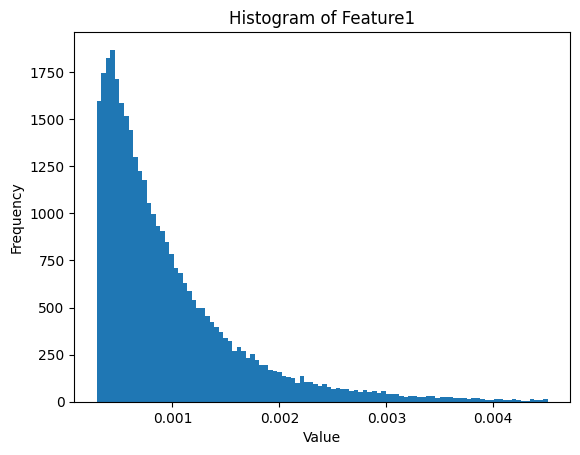

In [24]:
# Draw a histogram for a specific feature
import matplotlib.pyplot as plt

plt.hist(df3[target_var], bins=100)  # Adjust the number of bins as needed
plt.title('Histogram of Feature1')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [25]:
# baseline 변수만 빼보자.
my_list0 = X.columns.tolist()
# baseline_X_varlist = my_list0[:99] # 29가 맞는지 확인해야.
baseline_X_varlist = my_list0[:98] # 29가 맞는지 확인해야.
baseline_X_varlist.remove(target_var)
# baseline_X_varlist.remove('weekday_1')
# baseline_X_varlist.remove('weekday_2')
# baseline_X_varlist.remove('weekday_3')
# baseline_X_varlist.remove('weekday_4')
baseline_X_varlist

['realized_volatility_mean0',
 'realized_up_volatility_mean0',
 'realized_down_volatility_mean0',
 'num_trades',
 'lowest_return',
 'highest_return',
 'high_low_gap',
 'trade_vol',
 'trade_vol_top1p_ratio',
 'volume_power',
 'volume_power_top1p',
 'return',
 'BB_width_w20',
 'BB_width_w40',
 'BB_width_w10',
 'realized_volatility_mean0_60',
 'num_trades_60',
 'lowest_return_60',
 'highest_return_60',
 'high_low_gap_60',
 'trade_vol_60',
 'trade_vol_top1p_ratio_60',
 'volume_power_60',
 'volume_power_top1p_60',
 'realized_volatility_mean0_300',
 'num_trades_300',
 'lowest_return_300',
 'highest_return_300',
 'high_low_gap_300',
 'trade_vol_300',
 'trade_vol_top1p_ratio_300',
 'volume_power_300',
 'volume_power_top1p_300',
 'liq_last_1',
 'liq_last_2',
 'liq_last_5',
 'ep_liq_1',
 'ep_liq_2',
 'ep_liq_5',
 'bidask_spread_0',
 'bidask_spread_1',
 'highest_possible_return',
 'liq_last_1_60',
 'liq_last_2_60',
 'liq_last_5_60',
 'ep_liq_1_60',
 'ep_liq_2_60',
 'ep_liq_5_60',
 'liq_last_1_300

## 상관관계 높은 변수 drop 

In [34]:
import pandas as pd

# Assuming df is your DataFrame
# And target_var is the name of your dependent variable column

# Step 1: Compute the correlation matrix
corr_matrix = X.sample(n=1000, random_state=42).corr()

print("STEP1")
# Step 2: Identify pairs of highly correlated features
threshold = 0.8  # Define your threshold here
highly_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and abs(corr_matrix[i][j]) > threshold]

print("STEP2")

# Step 3 & 4: Drop features that are highly correlated but have lower correlation with target_var
to_drop = set()
for i, j in highly_corr_pairs:
    if abs(X[target_var].corr(X[i])) < abs(X[target_var].corr(X[j])):
        to_drop.add(i)
    else:
        to_drop.add(j)

print("STEP3")

# Dropping the identified features
df_dropped = X.drop(columns=to_drop)

print("STEP4")


STEP1
STEP2
STEP3
STEP4


In [35]:
import pickle

# Set을 List로 변환
corr_features = list(to_drop)

# List를 Pickle로 저장
with open('corr_del_list_{}_{}_{}_{}_v{}.pkl'.format(coin, target_var_3, threshold, data_id, vn), 'wb') as f:
    pickle.dump(corr_features, f)


In [91]:
# 저장된 Pickle 파일을 로드

import pickle

threshold = 0.8  # Define your threshold here
# file_name = 'corr_del_list_BTC_dv6_80_v202312122122_2.pkl'
file_name = 'corr_del_list_{}_{}_{}_{}_v{}.pkl'.format(coin, target_var_3, threshold, data_id, vn)
with open(file_name, 'rb') as f:
    corr_features = pickle.load(f)

print(len(corr_features))

40622


In [92]:
# correlation 이 다른 변수와 높은 변수는 삭제한다.
# X_raw_whole = X.copy()
# X_raw = X.tail(20000).copy()

# # Iterate over items in list B
# for item in baseline_X_varlist:
#     # Check if the item is not in list A
#     if item in corr_features:
#         # Add the item to list A
#         corr_features.remove(item)

X_raw = X.copy()

# correlation 계산을 했다면 돌리세요: #################################
X.drop(labels=corr_features, axis=1, inplace=True)

# target var 도 이제 X에서 제거한다.
X.drop(target_var, axis=1, inplace=True)


In [93]:
print('X.shape:', X.shape)
print('y.shape:', y.shape)

gc.collect()

X.shape: (33919, 17195)
y.shape: (33919,)


105

In [38]:
with timer('permutation importance'):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.inspection import permutation_importance
    import lightgbm as lgb

    # 데이터 분할
    test_size_setting = 0.2
    val_size_setting = 0.2

    # Assume you have your feature matrix X and target variable y
    X_train, X_test, y_train, y_test = train_test_split(X.sample(n=10000, random_state=42), y_category.sample(n=10000, random_state=42), test_size=test_size_setting, shuffle=False)

    # Define and train your LightGBM model
    lgb_model = lgb.LGBMClassifier(device = 'gpu')
    lgb_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lgb_model.predict(X_test)

    # Calculate the accuracy of the model on the test set
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Calculate permutation importances
    result = permutation_importance(lgb_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

    # Access the importances and feature names
    importances = result.importances_mean
    feature_names = X.columns  # Replace with your actual column names

    # rame to store the importances and feature names
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)


[LightGBM] [Info] Number of positive: 881, number of negative: 7119
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13265460
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 52046
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 52014 dense feature groups (396.85 MB) transferred to GPU in 0.353078 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110125 -> initscore=-2.089465
[LightGBM] [Info] Start training from score -2.089465
[LightGBM] [Info] Increasing preallocd_max_num_wg_ to 13004 for launching more workgroups
Accuracy: 0.999


In [ ]:
### SAVE
threshold = 0.8  # Define your threshold here
importance_df.to_csv('top_features_{}_{}_{}_{}_v{}.pkl'.format(coin, target_var_3, threshold, data_id, vn), index=False)
# dv7_return_for_backtesting 이 변수를 제거해주자 (추후에 쓰일 종속변수?)
filtered_importance_df = importance_df[~importance_df['Feature'].str.contains("dv7_return_for_backtesting")]
filtered_importance_df.to_csv('top_features_{}_{}_{}_{}_v{}.pkl'.format(coin, target_var_3, threshold, data_id, vn), index=False)

In [27]:
### READ 
import pandas as pd
threshold = 0.8  # Define your threshold here

importance_df = pd.read_csv('top_features_{}_{}_{}_{}_v{}.pkl'.format(coin, target_var_3, threshold, data_id, vn))
# importance_df = pd.read_csv('top_features_202312122122_2.csv')

pd.set_option('display.max_rows', None)

print(importance_df['Feature'].iloc[:128])

pd.set_option('display.max_rows', 10)


0       dv6_highest_possible_return_nn1_all_nn_m_p1_mean
1      dv6_highest_possible_return_nn1_high_low_gap_m...
2       dv6_highest_possible_return_nn2_all_nn_m_p1_mean
3        dv6_highest_possible_return_nn1_high5_nn_m_mean
4        dv6_highest_possible_return_nn2_high5_nn_m_mean
5      dv6_highest_possible_return_nn1_high_low_gap_3...
6        lowest_return_60_nn32_lowest_return_60_m_p1_std
7      dv6_highest_possible_return_nn2_high_low_gap_3...
8                                                   hour
9                 dv2_lowest_return_nn1_all_nn_m_p1_mean
10            BB_width_w10_nn8_volume_power_60_m_p1_mean
11                   tv_ratio_10m_1h_nn2_all_nn_m_p1_std
12     dv6_highest_possible_return_nn2_high5_abs_nn_m...
13     trade_vol_top1p_ratio_300_nn2_ep_liq_2_60_m_p1...
14         bidask_spread_1_nn32_high_low_gap_60_m_p1_std
15     end_price_ratio_30m_1h_nn8_orderbook_bias_5_m_...
16     lowest_return_nn32_end_price_ratio_c_1h_m_p1_mean
17     dv6_highest_possible_ret

## DEEP LEARNING

In [21]:
how_many = 128 ########################################################
list1 = importance_df['Feature'].iloc[:how_many].tolist()
# list3 = importance_df['Feature'].iloc[-how_many:].tolist()
# list2 = baseline_X_varlist
combined_list = list(set(list1 )) # +list3 + list2 +list3

X_selected = df3[combined_list] # 256을 바꾸어가면서 분석하자.

print(X_selected.shape)
test_size_setting = 0.2
val_size_setting = 0.2

_, X_raw_test, y_raw_temp, y_raw_test = train_test_split(df3, y, test_size=test_size_setting, shuffle = False) 

X_train, X_test, y_train, y_test = train_test_split(X, y_category, test_size=test_size_setting, shuffle=False)


(33919, 128)


In [68]:
# Training the model using PYTORCH 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Assuming your data has features X and target variable y
X_big = X_selected
y_big = y_category
# y_big = y_big.to_frame() # series into dataframe.


print("y_big.shape:", y_big.shape )
# Decompose the big data into train, val, and test sets
X_big_temp, X_big_test , y_big_temp, y_big_test = train_test_split(X_big, y_big, test_size=test_size_setting, shuffle = False)

# Manipulating the train and validation data
print("Before manipulation. len(X_big_train):", len(X_big_temp))
condition = (y_raw_temp > 1.0015) & (y_raw_temp < 1.002)
X_big_temp = X_big_temp[~condition]
y_big_temp = y_big_temp[~condition]
print("After manipulation. len(X_big_train):", len(X_big_temp))


X_big_train, X_big_val, y_big_train, y_big_val = train_test_split(X_big_temp, y_big_temp, test_size=val_size_setting, shuffle = False)

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_big_train = scaler.fit_transform(X_big_train)
X_big_val = scaler.transform(X_big_val)
X_big_test = scaler.transform(X_big_test)

y_big_train = y_big_train.values.squeeze()
y_big_val = y_big_val.values.squeeze()

# Convert to PyTorch tensors
X_big_train = torch.tensor(X_big_train.astype(np.float32)).to(device)
y_big_train = torch.tensor(y_big_train.astype(np.float32)).view(-1, 1).to(device)
X_big_val = torch.tensor(X_big_val.astype(np.float32)).to(device)
y_big_val = torch.tensor(y_big_val.astype(np.float32)).view(-1, 1).to(device)

# Create Dataset and DataLoader for batch processing
BATCH_SIZE = 1024 ########################################################
train_dataset = TensorDataset(X_big_train, y_big_train)
val_dataset = TensorDataset(X_big_val, y_big_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)


Using device: cuda
y_big.shape: (33919,)
Before manipulation. len(X_big_train): 27135
After manipulation. len(X_big_train): 25037


In [69]:
## FOCAL LOSS

import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# # Usage
# model = NeuralNetwork(X_big_train.shape[1]).to(device)
# criterion = FocalLoss(alpha=0.25, gamma=2.0, reduction='mean')
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [71]:
layer1_size = 64
layer2_size = 32
layer3_size = 16
layer4_size = 16
layer5_size = 16
layer6_size = 8
drop_out = 0.5

class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, layer1_size)
        self.bn1 = nn.BatchNorm1d(layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.bn2 = nn.BatchNorm1d(layer2_size)
        self.fc3 = nn.Linear(layer2_size, layer3_size)
        self.bn3 = nn.BatchNorm1d(layer3_size)
        self.fc4 = nn.Linear(layer3_size, layer4_size)
        self.bn4 = nn.BatchNorm1d(layer4_size)
        self.fc5 = nn.Linear(layer4_size, layer5_size)
        self.bn5 = nn.BatchNorm1d(layer5_size)
        self.fc6 = nn.Linear(layer5_size, layer6_size)
        self.bn6 = nn.BatchNorm1d(layer6_size)
        self.fc7 = nn.Linear(layer6_size, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.dropout(x, p=drop_out, train=self.training)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.dropout(x, p=drop_out, train=self.training)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.dropout(x, p=drop_out, train=self.training)

        x = torch.relu(self.bn4(self.fc4(x)))
        x = torch.dropout(x, p=drop_out, train=self.training)
        x = torch.relu(self.bn5(self.fc5(x)))
        x = torch.dropout(x, p=drop_out, train=self.training)

        x = torch.relu(self.bn6(self.fc6(x)))
        x = torch.sigmoid(self.fc7(x))
        return x

model = NeuralNetwork(X_big_train.shape[1]).to(device)

# criterion #############################
criterion = nn.BCELoss()
# criterion = FocalLoss(alpha=0.25, gamma=2.0, reduction='mean') # or 'sum'

LEARNING_RATE = 0.0005 ########################################################
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [72]:
num_epochs = 2000
best_val_loss = float('inf')
patience, trigger_times = 100, 0 ######################################
best_model = None

# Initialize lists to store losses
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_training_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item()

    # Average training loss for this epoch
    epoch_training_loss /= len(train_loader)
    training_losses.append(epoch_training_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_val_pred = model(X_val)
            val_loss += criterion(y_val_pred, y_val).item()

    
    val_loss /= len(val_loader)
    validation_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_training_loss}, Val Loss: {val_loss}') # loss.item()

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Restore the best model
model.load_state_dict(best_model)


Epoch 1, Loss: 0.7455283761024475, Val Loss: 0.7584830403327942
Epoch 2, Loss: 0.7157646358013153, Val Loss: 0.7118956565856933
Epoch 3, Loss: 0.6841415494680405, Val Loss: 0.6838293194770813
Epoch 4, Loss: 0.6577709078788757, Val Loss: 0.6639195203781127
Epoch 5, Loss: 0.6323120474815369, Val Loss: 0.6516486525535583
Epoch 6, Loss: 0.6052301287651062, Val Loss: 0.6393186807632446
Epoch 7, Loss: 0.5806194573640824, Val Loss: 0.6314216613769531
Epoch 8, Loss: 0.5578035414218903, Val Loss: 0.6212396502494812
Epoch 9, Loss: 0.5337910860776901, Val Loss: 0.6093298912048339
Epoch 10, Loss: 0.5116671830415725, Val Loss: 0.5993787288665772
Epoch 11, Loss: 0.489446884393692, Val Loss: 0.5848118782043457
Epoch 12, Loss: 0.4693173974752426, Val Loss: 0.5702649593353272
Epoch 13, Loss: 0.4488454654812813, Val Loss: 0.5578052759170532
Epoch 14, Loss: 0.42936702221632006, Val Loss: 0.545931613445282
Epoch 15, Loss: 0.4107286274433136, Val Loss: 0.5337234139442444
Epoch 16, Loss: 0.3931612357497215,

<All keys matched successfully>

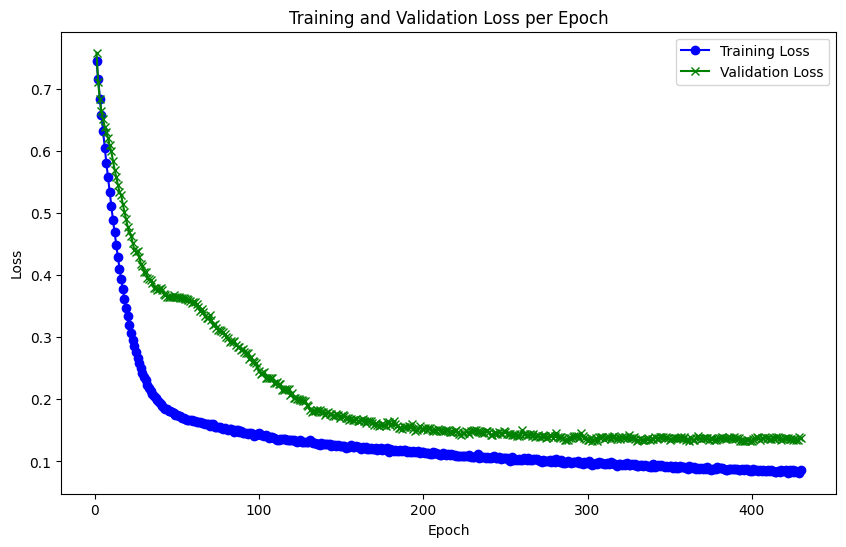

In [73]:
# Plotting the Graph
# Now that you have training_losses and validation_losses, you can plot them against the number of epochs. Here's the code to plot the graph:

import matplotlib.pyplot as plt

epochs = range(1, len(training_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, validation_losses, label='Validation Loss', color='green', marker='x')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
## TEST 

y_big_test = y_big_test.values.squeeze()
X_big_test = torch.tensor(X_big_test.astype(np.float32)).to(device)
y_big_test = torch.tensor(y_big_test.astype(np.float32)).view(-1, 1).to(device)
test_dataset = TensorDataset(X_big_test, y_big_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024)


Test Accuracy: 0.9279186320754716
Test Precision: 0.42857142857142855
Test Recall: 0.006147540983606557


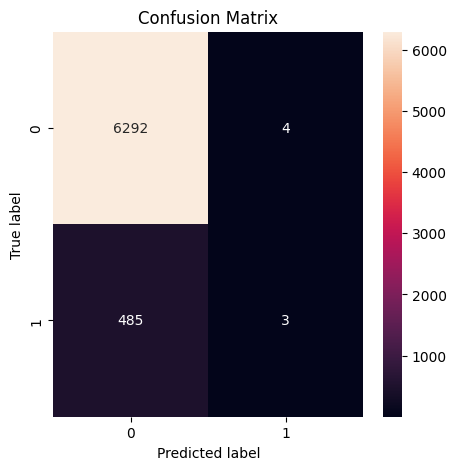

In [75]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def check_prediction_performance(test_loader):

    model.eval()
    y_pred_list = []
    y_pred_prob_list = []
    y_true_list = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_pred_prob_list.append(y_test_pred.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_pred_prob_list = [a.squeeze().tolist() for a in y_pred_prob_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]

    from sklearn.metrics import accuracy_score, precision_score, recall_score

    # Flatten the lists
    y_pred_list = [item for sublist in y_pred_list for item in sublist]
    y_true_list = [item for sublist in y_true_list for item in sublist]
    y_pred_prob_list = [item for sublist in y_pred_prob_list for item in sublist]

    # Calculate metrics
    accuracy = accuracy_score(y_true_list, y_pred_list)
    precision = precision_score(y_true_list, y_pred_list)
    recall = recall_score(y_true_list, y_pred_list)

    print(f'Test Accuracy: {accuracy}')
    print(f'Test Precision: {precision}')
    print(f'Test Recall: {recall}')

    # Compute confusion matrix
    cm = confusion_matrix(y_true_list, y_pred_list)

    # Plotting Confusion Matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return 


check_prediction_performance(test_loader)


Test Accuracy: 0.9562368359466417
Test Precision: 0.0
Test Recall: 0.0


c:\Users\hhkim\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


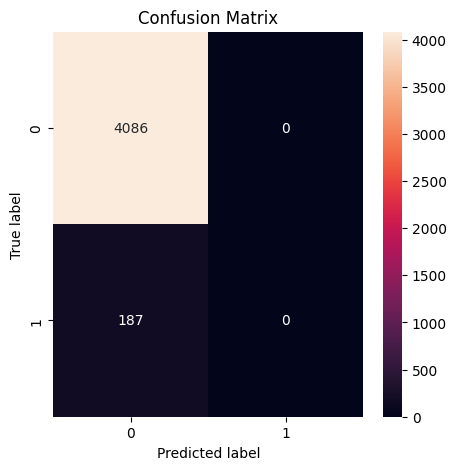

In [67]:
check_prediction_performance(val_loader)


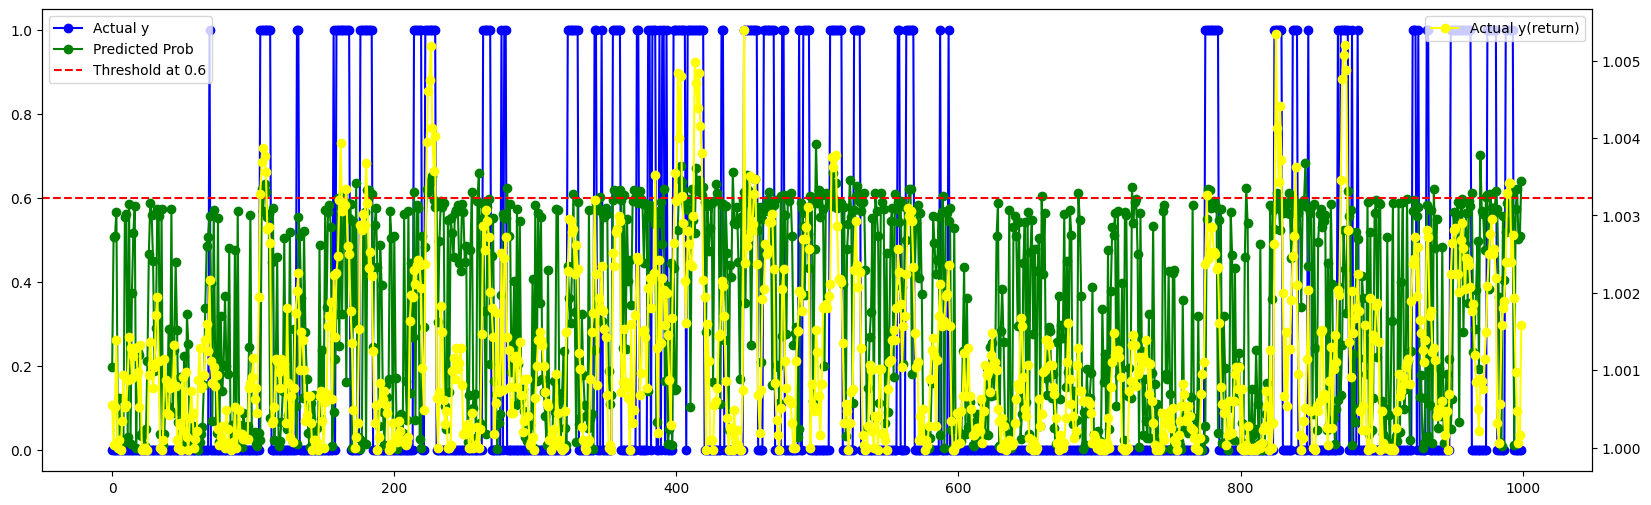

In [253]:
import matplotlib.pyplot as plt
begin_period = 0
end_period = begin_period + 1000

fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot time series A on the left y-axis
ax1.plot(y_true_list[begin_period:end_period], label='Actual y', color='blue', marker='o')  # 첫 100개 데이터
ax1.plot(y_pred_prob_list[begin_period:end_period], label='Predicted Prob', color='green', marker='o')  # 첫 100개 데이터
# ax1.plot(y_pred_list[begin_period:end_period], label='Predicted y', color='red', marker='x')  # 첫 100개 데이터

# Adding a horizontal line at 0.6 on the left y-axis
ax1.axhline(y=0.6, color='red', linestyle='--', label='Threshold at 0.6')

ax2 = ax1.twinx()
ax2.plot(y_raw_test.values[begin_period:end_period], label='Actual y(return)', color='yellow', marker='o')  # 첫 100개 데이터

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [245]:
## BECKTESTING

test_return = 1.0
temp_return = []
i=0
j=0
while i < len(y_pred_prob_list):
    if y_pred_prob_list[i] > 0.65: ### 0.6? 0.5?
        j=j+1
        if y_raw_test.values[i] < 1.002: 
            if pd.isna(X_raw_test['dv7_return_for_backtesting'].iloc[i]):
                i = i+10
                continue
            else:
                test_return = test_return  * (( X_raw_test['dv7_return_for_backtesting'].iloc[i]- 0.001 -0.0001)) 
                temp_return.append(X_raw_test['dv7_return_for_backtesting'].iloc[i])
                i = i+10
        else:
            test_return = test_return * (( 1.002 - 0.001 -0.0001))
            i = i+10
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y_big_test))
print('number of trading:', j)

def calculate_mean(lst):
    if not lst:
        return None  # Handle empty list to avoid division by zero
    return sum(lst) / len(lst)

print('average loss:', calculate_mean(temp_return))
print('min loss:', min(temp_return))


test_return: 1.0
len(y_selected_test)): 6485
number of trading: 0
average loss: None


ValueError: min() arg is an empty sequence

In [222]:
model.eval()
val_y_pred_list = []
val_y_true_list = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_val_pred = model(X_batch)
        y_pred_tag = torch.round(y_val_pred)
        val_y_pred_list.append(y_pred_tag.cpu().numpy())
        val_y_true_list.append(y_batch.cpu().numpy())

val_y_pred_list = [a.squeeze().tolist() for a in val_y_pred_list]
val_y_true_list = [a.squeeze().tolist() for a in val_y_true_list]

val_y_pred_list = [item for sublist in val_y_pred_list for item in sublist]
val_y_true_list = [item for sublist in val_y_true_list for item in sublist]

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate metrics
val_accuracy = accuracy_score(val_y_true_list, val_y_pred_list)
val_precision = precision_score(val_y_true_list, val_y_pred_list)
val_recall = recall_score(val_y_true_list, val_y_pred_list)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}')

Validation Accuracy: 0.8451208594449419
Validation Precision: 0.3002610966057441
Validation Recall: 0.5958549222797928


In [223]:
model.eval()  # Set the model to evaluation mode
train_y_pred_list = []
train_y_true_list = []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_train_pred = model(X_batch)
        y_pred_tag = torch.round(y_train_pred)
        train_y_pred_list.append(y_pred_tag.cpu().numpy())
        train_y_true_list.append(y_batch.cpu().numpy())

train_y_pred_list = [item for sublist in train_y_pred_list for item in sublist]
train_y_true_list = [item for sublist in train_y_true_list for item in sublist]

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate metrics
train_accuracy = accuracy_score(train_y_true_list, train_y_pred_list)
train_precision = precision_score(train_y_true_list, train_y_pred_list)
train_recall = recall_score(train_y_true_list, train_y_pred_list)

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}')


Train Accuracy: 0.9542834760226064
Train Precision: 0.6461466165413534
Train Recall: 0.9555246699096595


In [40]:
# SAVE the pytorch model

torch.save(best_model, 'model.pth')

### SAVE THE MODEL ###
import lightgbm as lgb
import joblib

scaler_mean = scaler.mean_
scaler_std = np.sqrt(scaler.var_)
np.savez('D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\scaler_params_{}_v{}.npz'.format(coin,vn), mean = scaler_mean, std=scaler_std)

# Save the scaler to a file using joblib
joblib.dump(scaler, '.\\trading program\\scaler_{}_v{}.joblib'.format(coin,vn))

# # Save the trained model to a file
# joblib.dump(bst, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_classifier_model_{}_v{}.joblib'.format(coin,vn))
# print(coin, vn)
X_selected_vars_list = X_selected.columns.tolist()
joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,vn))
X_baseline_vars_list = X_baseline.columns.tolist()
joblib.dump(X_baseline_vars_list, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,vn))
# Find common values of A and B
common_values = set(X_selected_vars_list) & set(X_baseline_vars_list)

# Get A' (unique values in A not present in B)
baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)
# X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,vn))

['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v202312122122_2.pkl']

In [91]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import BatchNormalization
# import tensorflow as tf

# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# # # Load your big dataset
# # big_data_path = 'path_to_big_data.csv'
# # big_data = pd.read_csv(big_data_path)

# # # Load your smaller dataset for transfer learning
# # small_data_path = 'path_to_small_data.csv'
# # small_data = pd.read_csv(small_data_path)

# # Assuming your data has features X and target variable y
# X_big = X_selected
# y_big = y_category

# # X_small = small_data.drop('target_variable', axis=1)
# # y_small = small_data['target_variable']

# # Decompose the big data into train, val, and test sets
# X_big_temp, X_big_test , y_big_temp, y_big_test = train_test_split(X_big, y_big, test_size=test_size_setting, shuffle = False)

# # Manipulating the train and validation data
# print("Before manipulation. len(X_big_train):", len(X_big_temp))
# condition = (y_raw_temp > 1.001) & (y_raw_temp < 1.002)
# X_big_temp = X_big_temp[~condition]
# y_big_temp = y_big_temp[~condition]
# print("After manipulation. len(X_big_train):", len(X_big_temp))

# X_big_train, X_big_val, y_big_train, y_big_val = train_test_split(X_big_temp, y_big_temp, test_size=val_size_setting, shuffle = False)

# # Normalize the data using StandardScaler
# scaler = StandardScaler()
# X_big_train = scaler.fit_transform(X_big_train)
# X_big_val = scaler.transform(X_big_val)
# X_big_test = scaler.transform(X_big_test)

# # X_small = scaler.transform(X_small)

# dropout_rate = 0.5
# # Create the fully connected deep learning model
# model = Sequential()
# model.add(Dense(64, input_dim=X_big_train.shape[1], activation='relu'))
# model.add(Dropout(dropout_rate))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(dropout_rate))
# model.add(BatchNormalization())
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(dropout_rate))
# model.add(BatchNormalization())
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(dropout_rate))   
# model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification (0/1)

# # Compile the model
# optimizer = Adam(learning_rate=0.00005)
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # Define early stopping criteria
# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# # Display the model summary
# model.summary()

# num_of_epoch = 1000
# # batch_size = 1024
# # Train the model on the big dataset with early stopping
# history = model.fit(X_big_train, y_big_train, epochs=num_of_epoch, # batch_size = batch_size,
#                     validation_data=(X_big_val, y_big_val),
#                     callbacks=[early_stopping])


Num GPUs Available:  0
Before manipulation. len(X_big_train): 8101
After manipulation. len(X_big_train): 6645
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                8128      
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_34 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 batch_nor

In [93]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# # Evaluate the model on the test set
# y_test_pred_probs = model.predict(X_big_test)
# y_val_pred_probs = model.predict(X_big_val)

# y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()
# y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()

# # Calculate accuracy, precision, recall, and confusion matrix
# accuracy2 = accuracy_score(y_big_val, y_val_pred)
# precision2 = precision_score(y_big_val, y_val_pred)
# recall2 = recall_score(y_big_val, y_val_pred)
# conf_matrix2 = confusion_matrix(y_big_val, y_val_pred)

# # Print the evaluation metrics
# print(f'val Accuracy: {accuracy2:.4f}')
# print(f'val Precision: {precision2:.4f}')
# print(f'val Recall: {recall2:.4f}')
# print(f'val Confusion Matrix:\n{conf_matrix2}')

# # Calculate accuracy, precision, recall, and confusion matrix
# accuracy = accuracy_score(y_big_test, y_test_pred)
# precision = precision_score(y_big_test, y_test_pred)
# recall = recall_score(y_big_test, y_test_pred)
# conf_matrix = confusion_matrix(y_big_test, y_test_pred)

# # Print the evaluation metrics
# print(f'test Accuracy: {accuracy:.4f}')
# print(f'test Precision: {precision:.4f}')
# print(f'test Recall: {recall:.4f}')
# print(f'test Confusion Matrix:\n{conf_matrix}')

21/21 [==============================] - 0s 676us/step
val Accuracy: 0.7504
val Precision: 0.7403
val Recall: 0.2808
val Confusion Matrix:
[[442  20]
 [146  57]]
test Accuracy: 0.7869
test Precision: 0.7470
test Recall: 0.4697
test Confusion Matrix:
[[274  21]
 [ 70  62]]


In [ ]:
import matplotlib.pyplot as plt
begin_period = 0
end_period = begin_period + 10000

fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot time series A on the left y-axis
ax1.plot(y_big_test.values[begin_period:end_period], label='Actual y', color='blue', marker='o')  # 첫 100개 데이터
ax1.plot(y_test_pred_probs[begin_period:end_period], label='Predicted Prob', color='green', marker='o')  # 첫 100개 데이터
ax1.plot(y_test_pred[begin_period:end_period], label='Predicted y', color='red', marker='x')  # 첫 100개 데이터

ax2 = ax1.twinx()
ax2.plot(y_raw_test.values[begin_period:end_period], label='Actual y(return)', color='yellow', marker='o')  # 첫 100개 데이터

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [112]:
## BECKTESTING
test_return = 1.0
temp_return = []
i=0
j=0
while i < len(y_big_test):
    if y_test_pred_probs[i] > 0.5: ### 0.6? 0.5?
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y_raw_test.values[i] < 1.002: 
            if pd.isna(X_raw_test['return_for_backtesting'].iloc[i]):
                i = i+10
                continue
            else:
                test_return = test_return  * (( X_raw_test['return_for_backtesting'].iloc[i]- 0.001 -0.0001)) #### X_raw_test['return'] 이게 아니고.. 10분 뒤의 것을 준비해야...
                temp_return.append(X_raw_test['return'].iloc[i])
                i = i+10
        else:
            test_return = test_return * (( 1.002 - 0.001 -0.0001))
            i = i+10
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y_big_test))
print('number of trading:', j)

def calculate_mean(lst):
    if not lst:
        return None  # Handle empty list to avoid division by zero
    return sum(lst) / len(lst)

print('average loss:', calculate_mean(temp_return))
print('min loss:', min(temp_return))


test_return: 0.9997375477900704
len(y_selected_test)): 427
number of trading: 18
average loss: 0.9968807697296143
min loss: 0.9904893


### SAVE THE DEEP LEARNING MODEL

In [113]:
### SAVE THE MODEL ###
import lightgbm as lgb
import joblib

scaler_mean = scaler.mean_
scaler_std = np.sqrt(scaler.var_)
np.savez('D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\scaler_params_{}_v{}.npz'.format(coin,vn), mean = scaler_mean, std=scaler_std)

# Save the scaler to a file using joblib
joblib.dump(scaler, '.\\trading program\\scaler_{}_v{}.joblib'.format(coin,vn))

## deep learning model
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\model_architecture_{}_v{}.json".format(coin,vn), "w") as json_file:
    json_file.write(model_json)
# Save the model weights to an HDF5 file
model.save_weights("D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\model_weights_{}_v{}.h5".format(coin,vn))

# # Save the trained model to a file
# joblib.dump(bst, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_classifier_model_{}_v{}.joblib'.format(coin,vn))
# print(coin, vn)
X_selected_vars_list = X_selected.columns.tolist()
joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,vn))
X_baseline_vars_list = X_baseline.columns.tolist()
joblib.dump(X_baseline_vars_list, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,vn))
# Find common values of A and B
common_values = set(X_selected_vars_list) & set(X_baseline_vars_list)

# Get A' (unique values in A not present in B)
baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)
# X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,vn))



['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v202312122122_2.pkl']

In [ ]:
# Now, transfer learning on the smaller dataset
# Set the weights of the initial layers from the big model
for layer in model.layers[:-1]:
    layer.trainable = False

# Compile the model again for transfer learning
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the small dataset with early stopping
history_transfer = model.fit(X_small, y_small, epochs=transfer_epochs,
                             validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the big and small test sets
big_test_loss, big_test_accuracy = model.evaluate(X_big_test, y_big_test)
small_test_loss, small_test_accuracy = model.evaluate(X_small, y_small)

print(f"Big Test Accuracy: {big_test_accuracy}")
print(f"Small Test Accuracy: {small_test_accuracy}")

## LGBM

In [32]:
how_many = 512 ########################################################
list1 = importance_df['Feature'].iloc[:how_many].tolist()
# list3 = importance_df['Feature'].iloc[-how_many:].tolist()
# print(baseline_X_varlist)

list2 = baseline_X_varlist
combined_list = list(set( list1 + list2)) # +list3 list1 +
# print(combined_list)
X_selected = df3[combined_list] # 256을 바꾸어가면서 분석하자.

print(X_selected.shape)
test_size_setting = 0.2
val_size_setting = 0.2

_, X_raw_test, y_raw_temp, y_raw_test = train_test_split(df3, y, test_size=test_size_setting, shuffle = False) 
X_train, X_test, y_train, y_test = train_test_split(X, y_category, test_size=test_size_setting, shuffle=False)

# print(combined_list)

(34004, 606)


In [35]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming your data has features X and target variable y
X_big = X_selected
y_big = y_category
print("# of features:", X_selected.shape[1])

# Decompose the big data into train, val, and test sets
X_big_temp, X_big_test , y_big_temp, y_big_test = train_test_split(X_big, y_big, test_size=test_size_setting, shuffle = False)

# Manipulating the train and validation data
print("Before manipulation. len(X_big_train):", len(X_big_temp))
condition = (y_raw_temp > treshold_of_vol*0.8) & (y_raw_temp < treshold_of_vol)
X_big_temp = X_big_temp[~condition]
y_big_temp = y_big_temp[~condition]
print("After manipulation. len(X_big_train):", len(X_big_temp))

X_big_train, X_big_val, y_big_train, y_big_val = train_test_split(X_big_temp, y_big_temp, test_size=val_size_setting, shuffle = False)

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_big_train = scaler.fit_transform(X_big_train)
X_big_val = scaler.transform(X_big_val)
X_big_test = scaler.transform(X_big_test)


# Create LGBM datasets
train_data = lgb.Dataset(X_big_train, label=y_big_train)
val_data = lgb.Dataset(X_big_val, label=y_big_val, reference=train_data)

params = {
    # 'objective': 'regression',  # 회귀 문제
    # 'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
    # 'metric': 'l2',             # Mean Squared Error
    'device': "gpu",
    'num_leaves': 200,          # 리프 노드의 최대 수 (mean_leaves에 가깝게 설정) # 100
    'min_data_in_leaf': 50,     # 한 리프에 최소한으로 필요한 레코드 수
    'max_depth': 15,            # 최대 깊이 (max_depth에 맞춤) # 15
    'learning_rate': 0.01,      # 학습률 # 0.05
    'feature_fraction': 0.9,    # 트리를 학습할 때마다 선택할 피처의 비율
    'bagging_fraction': 0.8,    # 트리를 학습할 때마다 선택할 데이터의 비율
    'bagging_freq': 7,          # bagging의 빈도
    'n_estimators': 1000,     # 총 트리의 수 (number_of_trees에 맞춤)
    # "reg_alpha": 6,
    # "reg_lambda": 0.08,
    # "min_child_samples": 64,  # Minimum number of data points in a leaf

}

# params = {
#     # 'objective': 'regression',  # 회귀 문제
#     # 'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
#     # 'metric': 'l2',             # Mean Squared Error
#     'num_leaves': 100,          # 리프 노드의 최대 수 (mean_leaves에 가깝게 설정) # 100
#     'min_data_in_leaf': 50,     # 한 리프에 최소한으로 필요한 레코드 수
#     'max_depth': 15,            # 최대 깊이 (max_depth에 맞춤) # 15
#     'learning_rate': 0.01,      # 학습률 # 0.05
#     'feature_fraction': 0.9,    # 트리를 학습할 때마다 선택할 피처의 비율
#     'bagging_fraction': 0.8,    # 트리를 학습할 때마다 선택할 데이터의 비율
#     'bagging_freq': 7,          # bagging의 빈도
#     'n_estimators': 150     # 총 트리의 수 (number_of_trees에 맞춤)
# }

# lgb_params = {
#         "objective": "mae",
#         "n_estimators": 5500,
#         "num_leaves": 465,
#         "subsample": 0.65791,
#         "colsample_bytree": 0.7,
#         "learning_rate": 0.00877,  # 0.00877
#         "n_jobs": 4,
#         "device": "gpu",
#         "verbosity": -1,
#         "importance_type": "gain",
#         "max_depth": 14,  # Maximum depth of the tree
#         "min_child_samples": 132,  # Minimum number of data points in a leaf
#         "reg_alpha": 6,  # L1 regularization term
#         "reg_lambda": 0.08,  # L2 regularization term
#     }

# Train the model with the best hyperparameters
bst = lgb.train(
    {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'},
    train_data,
    num_boost_round=1000,
    valid_sets=[val_data],
    # early_stopping_rounds=50,
    # verbose_eval=10
)


# of features: 606
Before manipulation. len(X_big_train): 27203
After manipulation. len(X_big_train): 25394


c:\Users\hhkim\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2008, number of negative: 18307
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 149757
[LightGBM] [Info] Number of data points in the train set: 20315, number of used features: 606
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 588 dense feature groups (11.39 MB) transferred to GPU in 0.015380 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098843 -> initscore=-2.210144
[LightGBM] [Info] Start training from score -2.210144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_the_model(bst, X_big_train, X_big_val, X_big_test, y_big_train, y_big_val, y_big_test):
    # Evaluate the trained model
    y_train_pred = bst.predict(X_big_train, num_iteration=bst.best_iteration)
    y_val_pred = bst.predict(X_big_val, num_iteration=bst.best_iteration)
    y_test_pred = bst.predict(X_big_test, num_iteration=bst.best_iteration)

    # Convert predicted probabilities to binary predictions
    y_train_pred_binary = (y_train_pred > 0.5).astype(int)
    y_val_pred_binary = (y_val_pred > 0.5).astype(int)
    y_test_pred_binary = (y_test_pred > 0.5).astype(int)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_big_train, y_train_pred_binary)
    val_accuracy = accuracy_score(y_big_val, y_val_pred_binary)
    test_accuracy = accuracy_score(y_big_test, y_test_pred_binary)

    # Calculate precision
    train_precision = precision_score(y_big_train, y_train_pred_binary)
    val_precision = precision_score(y_big_val, y_val_pred_binary)
    test_precision = precision_score(y_big_test, y_test_pred_binary)

    # calculate recall
    # recall = recall_score(y_test, y_pred)
    train_recall = recall_score(y_big_train, y_train_pred_binary)
    val_recall = recall_score(y_big_val, y_val_pred_binary)
    test_recall = recall_score(y_big_test, y_test_pred_binary)

    print('==== ACCURACY ====')
    print(f'Training Accuracy: {train_accuracy}')
    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Test Accuracy: {test_accuracy}')
    print('==== PRECISION ====')
    print(f'Training Precision: {train_precision}')
    print(f'Validation Precision: {val_precision}')
    print(f'Test Precision: {test_precision}')
    print('==== RECALL ====')
    print(f'Training recall: {train_recall}')
    print(f'Validation recall: {val_recall}')
    print(f'Test recall: {test_recall}')

    print('==== HOW MANY 1s ====')
    print('==== train ====')
    print('# of 1s:', sum(y_big_train))
    print('# of 1s:', sum(y_train_pred_binary))

    print('==== validation ====')
    print('# of 1s:', sum(y_big_val))
    print('# of 1s:', sum(y_val_pred_binary))

    print('==== test ====')
    print('# of 1s:', sum(y_big_test))
    print('# of 1s:', sum(y_test_pred_binary))

    return y_test_pred, y_test_pred_binary

y_test_pred, y_test_pred_binary = evaluate_the_model(bst, X_big_train, X_big_val, X_big_test, y_big_train, y_big_val, y_big_test)

==== ACCURACY ====
Training Accuracy: 1.0
Validation Accuracy: 0.9241976767080133
Test Accuracy: 0.8554624319952948
==== PRECISION ====
Training Precision: 1.0
Validation Precision: 0.7657657657657657
Test Precision: 0.7111913357400722
==== RECALL ====
Training recall: 1.0
Validation recall: 0.19144144144144143
Test recall: 0.17909090909090908
==== HOW MANY 1s ====
==== train ====
# of 1s: 2008
# of 1s: 2008
==== validation ====
# of 1s: 444
# of 1s: 111
==== test ====
# of 1s: 1100
# of 1s: 277


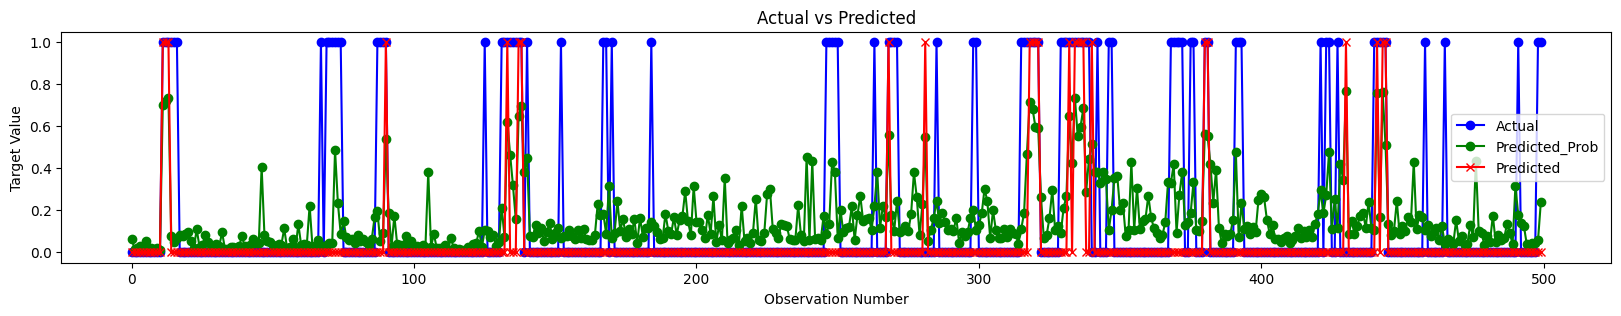

In [31]:
begin_period = 0
end_period = begin_period + 500

import matplotlib.pyplot as plt

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(20, 3))
plt.plot(y_big_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(y_test_pred[begin_period:end_period], label='Predicted_Prob', color='green', marker='o')  # 첫 100개 데이터
plt.plot(y_test_pred_binary[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
# plt.plot(y_selected_train.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
# plt.plot(y_selected_train_pred[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()



In [98]:
## BECKTESTING
test_return = 1.0
temp_return = []
i=0
j=0
while i < len(y_big_test):
    if y_test_pred[i] > 0.7:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y_big_test.values[i] < 1.002: 
            test_return = test_return  * (( X_raw_test['dv7_return_for_backtesting'].iloc[i]- 0.001 -0.0001))
            temp_return.append(X_raw_test['dv7_return_for_backtesting'].iloc[i])
            i = i+10
        else:
            test_return = test_return * (( 1.002 - 0.001 -0.0001))
            i = i+10
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y_big_test))
print('number of trading:', j)

def calculate_mean(lst):
    if not lst:
        return None  # Handle empty list to avoid division by zero
    return sum(lst) / len(lst)

print('average loss:', calculate_mean(temp_return))
print('min loss:', min(temp_return))


test_return: 1.0167871275503917
len(y_selected_test)): 3392
number of trading: 11
average loss: 1.0026157986034046
min loss: 1.0


#### ############## 최신 데이터로 다시 한번 test ###################


In [235]:
df4 = pd.read_pickle("./output/BTC_baseline_and_nn_features_dv6_202312122122_v7_new.pkl")
# df3_raw = df3.copy()
print(df4.shape)


(3915, 57822)


In [236]:
df4['dv7_return_for_backtesting'] = df4['return'].shift(-10)

In [237]:
X2_selected = df4[combined_list] 
y2 = df4[target_var]  
y2_category = (y2 > 1.002).astype(int)
gc.collect()

3541

In [238]:
# Evaluate the trained model

X2_selected_scaled = scaler.transform(X2_selected)
y2_test_pred = bst.predict(X2_selected_scaled, num_iteration=bst.best_iteration)
y2_test_pred_binary = (y2_test_pred > 0.5).astype(int)
test2_accuracy = accuracy_score(y2_category, y2_test_pred_binary)
test2_precision = precision_score(y2_category, y2_test_pred_binary)
test2_recall = recall_score(y2_category, y2_test_pred_binary)

print(f'Test Accuracy: {test2_accuracy}')
print(f'Test Precision: {test2_precision}')
print(f'Test recall: {test2_recall}')

print('==== test ====')
print('# of 1s:', sum(y2_category))
print('# of 1s:', sum(y2_test_pred_binary))

Test Accuracy: 0.8687100893997446
Test Precision: 0.7651515151515151
Test recall: 0.5088161209068011
==== test ====
# of 1s: 794
# of 1s: 528


In [166]:
X2_selected_scaled_df = pd.DataFrame(X2_selected_scaled)
X2_selected_scaled_df.columns = combined_list
X2_selected_scaled_df.to_csv("D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\output\\temptemp2.csv")

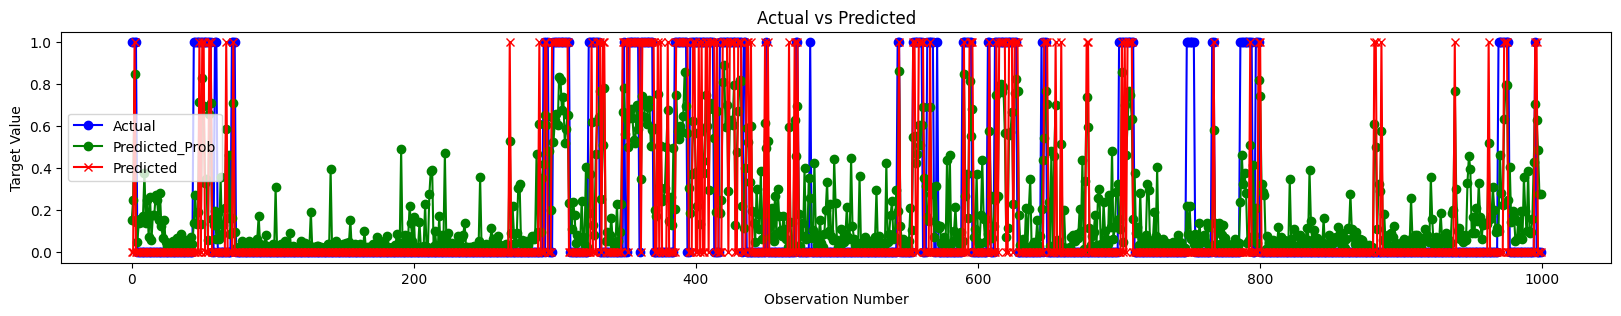

In [239]:
begin_period = 2000
end_period = begin_period + 1000

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(y2_category.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(y2_test_pred[begin_period:end_period], label='Predicted_Prob', color='green', marker='o')  # 첫 100개 데이터
plt.plot(y2_test_pred_binary[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()



In [242]:
## BECKTESTING
test_return = 1.0
temp_return = []
i=0
j=0
while i < len(y2_category):
    if y2_test_pred[i] > 0.7:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y2.values[i] < 1.002: 
            test_return = test_return  * (( df4['dv7_return_for_backtesting'].iloc[i]- 0.001 -0.0001))
            temp_return.append(df4['dv7_return_for_backtesting'].iloc[i])
            i = i+1
        else:
            test_return = test_return * (( 1.002 - 0.001 -0.0001))
            i = i+1
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y2_category))
print('number of trading:', j)


def calculate_mean(lst):
    if not lst:
        return None  # Handle empty list to avoid division by zero
    return sum(lst) / len(lst)

print('average loss:', calculate_mean(temp_return))
print('min loss:', min(temp_return))


test_return: 1.1183096629279536
len(y_selected_test)): 3915
number of trading: 230
average loss: 0.9989375895069491
min loss: 0.9923987


### SAVE the LGBM model

In [243]:
import lightgbm as lgb
import joblib


coin = 'BTC'
machine_num = '20240107'

scaler_mean = scaler.mean_
scaler_std = np.sqrt(scaler.var_)
np.savez('D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\scaler_params_{}_v{}.npz'.format(coin,machine_num), mean = scaler_mean, std=scaler_std)

# Save the scaler to a file using joblib
joblib.dump(scaler, '.\\trading program\\scaler_{}_v{}.joblib'.format(coin,machine_num))

# Save the trained model to a file
joblib.dump(bst, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_classifier_model_{}_v{}.joblib'.format(coin,machine_num))
print(coin, vn)
X_selected_vars_list = X_selected.columns.tolist()
joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,machine_num))
X_baseline_vars_list = X_baseline.columns.tolist()
joblib.dump(X_baseline_vars_list, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,machine_num))
# Find common values of A and B
common_values = set(X_selected_vars_list) & set(X_baseline_vars_list)

# Get A' (unique values in A not present in B)
baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)
# X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,machine_num))



BTC 7_new


['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v20240106.pkl']

## 최신 및 과거데이터를 합해서 train/val/test 나누고 모델 학습 및 테스트

In [6]:
df3 = pd.read_pickle("./output/{}_baseline_and_nn_features_{}_{}_v{}.pkl".format(coin, target_var_3, data_id, vn))
df3_raw = df3.copy()

df4 = pd.read_pickle("./output/BTC_baseline_and_nn_features_dv6_202312122122_v7_new.pkl")
df4_raw = df4.copy()

In [7]:
# baseline 변수만 빼보자.
my_list0 = df4_raw.columns.tolist()
baseline_X_varlist = my_list0[:102] # 98가 맞는지 확인해야.
baseline_X_varlist

['realized_volatility_mean0',
 'realized_up_volatility_mean0',
 'realized_down_volatility_mean0',
 'num_trades',
 'lowest_return',
 'highest_return',
 'high_low_gap',
 'trade_vol',
 'trade_vol_top1p_ratio',
 'volume_power',
 'volume_power_top1p',
 'return',
 'log_return_temp',
 'BB_width_w20',
 'BB_width_w40',
 'BB_width_w10',
 'dv5_realized_volatility_mean0',
 'dv2_lowest_return',
 'realized_volatility_mean0_60',
 'num_trades_60',
 'lowest_return_60',
 'highest_return_60',
 'high_low_gap_60',
 'trade_vol_60',
 'trade_vol_top1p_ratio_60',
 'volume_power_60',
 'volume_power_top1p_60',
 'realized_volatility_mean0_300',
 'num_trades_300',
 'lowest_return_300',
 'highest_return_300',
 'high_low_gap_300',
 'trade_vol_300',
 'trade_vol_top1p_ratio_300',
 'volume_power_300',
 'volume_power_top1p_300',
 'liq_last_1',
 'liq_last_2',
 'liq_last_5',
 'ep_liq_1',
 'ep_liq_2',
 'ep_liq_5',
 'bidask_spread_0',
 'bidask_spread_1',
 'highest_possible_return',
 'dv6_highest_possible_return',
 'liq_last

In [23]:
how_many = 256
list1 = importance_df['Feature'].iloc[:how_many].tolist()
combined_list = list(set( list1)) # +list3 list1 ++ list2
combined_list = [s for s in combined_list if "hausdorff" not in s]
combined_list

['trade_vol_top1p_ratio_300_nn32_tv_ratio_10m_1h_m_p1_mean',
 'dv6_highest_possible_return_nn16_all_nn_m_p1_std',
 'volume_power_300_nn32_lowest_return_60_m_p1_mean',
 'volume_power_top1p_300_nn8_tvpl2_m_p1_mean',
 'bidask_spread_1_nn32_return_m_p1_mean',
 'dv6_highest_possible_return_nn8_high_low_gap_m_p1_mean',
 'tvpl1_nn1_all_nn_m_p1_mean',
 'trade.tau_nn32_ep_liq_5_60_m_p1_std',
 'highest_return_60_nn2_tv_ratio_10m_1h_m_p1_mean',
 'num_trades_ratio_10m_1h_nn32_lowest_return_m_p1_mean',
 'volume_power_top1p_60_nn32_ep_liq_2_300_m_p1_mean',
 'BB_width_w40_nn8_high_low_gap_m_p1_std',
 'return_nn16_ep_liq_2_300_m_p1_mean',
 'volume_power_top1p_300_nn2_tvpl_ep5_m_p1_mean',
 'lowest_return_60_nn8_highest_return_60_m_p1_mean',
 'volume_power_top1p_nn32_ep_liq_1_300_m_p1_mean',
 'volume_power_nn32_end_price_ratio_c_1h_m_p1_mean',
 'trade_vol_top1p_ratio_nn32_lowest_return_300_m_p1_std',
 'volume_power_top1p_nn2_tv_ratio_10m_1h_m_p1_std',
 'dv6_highest_possible_return_nn2_BB_width_w40_m_p1_

In [24]:
def preprocessing_1 (df: pd.DataFrame, combined_list):
    df = df.drop('time_id', axis=1) 
    df['dv7_return_for_backtesting'] = df['return'].shift(-10)
    low_percentile1 = df['num_trades'].quantile(0.01)
    high_percentile1 = df['num_trades'].quantile(0.99)
    low_percentile2 = df['realized_volatility_mean0'].quantile(0.01)
    high_percentile2 = df['realized_volatility_mean0'].quantile(0.99)
    low_percentile3 = df['trade_vol'].quantile(0.01)
    high_percentile3 = df['trade_vol'].quantile(0.99)
    low_percentile4 = df[target_var].quantile(0.10)
    high_percentile4 = df[target_var].quantile(0.99)
    df = df[(df['num_trades'] > low_percentile1) & (df['num_trades'] < high_percentile1)]
    df = df[(df['realized_volatility_mean0'] > low_percentile2) & (df['realized_volatility_mean0'] < high_percentile2)]
    df = df[(df['trade_vol'] > low_percentile3) & (df['trade_vol'] < high_percentile3)]
    df = df[(df[target_var] > low_percentile4) & (df[target_var] < high_percentile4)]

    X_selected = df[combined_list] # 256을 바꾸어가면서 분석하자.

    return df, X_selected

In [56]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
from sklearn.preprocessing import StandardScaler


dv_list = ['dv2_lowest_return', 'dv6_highest_possible_return', 'dv5_realized_volatility_mean0'] 
dv_list.remove(target_var)

test_size_setting = 0.1
val_size_setting = 0.2

price_threshold = 1.003

print(df3.shape)
df3, X_selected_df3 = preprocessing_1(df3_raw, combined_list)

y = df3[target_var]  
y_category = (y > price_threshold).astype(int)
y_category.describe()
X_raw_temp, X_raw_test, y_raw_temp, y_raw_test = train_test_split(df3, y, test_size=test_size_setting, shuffle = False) 
X_raw_train, X_raw_val, y_raw_train, y_raw_val = train_test_split(X_raw_temp, y_raw_temp, test_size=val_size_setting, shuffle = False)

print(df4.shape)
df4, X2_selected_df4 = preprocessing_1(df4_raw, combined_list)

y2 = df4[target_var]  
y2_category = (y2 > price_threshold).astype(int)
y2_category.describe()
X2_raw_temp, X2_raw_test, y2_raw_temp, y2_raw_test = train_test_split(df4, y2, test_size=test_size_setting, shuffle = False) 
X2_raw_train, X2_raw_val, y2_raw_train, y2_raw_val = train_test_split(X2_raw_temp, y2_raw_temp, test_size=val_size_setting, shuffle = False)

X_raw_test = pd.concat([X_raw_test, X2_raw_test], axis=0)

y_raw_train = pd.concat([y_raw_train, y2_raw_train], axis=0)
y_raw_val = pd.concat([y_raw_val, y2_raw_val], axis=0)
y_raw_test = pd.concat([y_raw_test, y2_raw_test], axis=0)

X_big_temp, X_big_test , y_big_temp, y_big_test = train_test_split(X_selected_df3, y_category, test_size=test_size_setting, shuffle = False)
X2_big_temp, X2_big_test , y2_big_temp, y2_big_test = train_test_split(X2_selected_df4, y2_category, test_size=test_size_setting, shuffle = False)

X_big_train, X_big_val, y_big_train, y_big_val = train_test_split(X_big_temp, y_big_temp, test_size=val_size_setting, shuffle = False)
X2_big_train, X2_big_val, y2_big_train, y2_big_val = train_test_split(X2_big_temp, y2_big_temp, test_size=val_size_setting, shuffle = False)

X_big_train = pd.concat([X_big_train, X2_big_train], axis=0)
X_big_val = pd.concat([X_big_val, X2_big_val], axis=0)
y_big_train = pd.concat([y_big_train, y2_big_train], axis=0)
y_big_val = pd.concat([y_big_val, y2_big_val], axis=0)
X_big_test = pd.concat([X_big_test, X2_big_test], axis=0)
y_big_test = pd.concat([y_big_test, y2_big_test], axis=0)

print("Before manipulation. len(X_big_train):", len(X_big_train))
condition1 = (y_raw_train > price_threshold - 0.0005) & (y_raw_train < price_threshold)
X_big_train = X_big_train[~condition1]
y_big_train = y_big_train[~condition1]
print("After manipulation. len(X_big_train):", len(X_big_train))

print("Before manipulation. len(X_big_train):", len(X_big_val))
condition2 = (y_raw_val > price_threshold - 0.0005) & (y_raw_val < price_threshold)
X_big_val = X_big_val[~condition2]
y_big_val = y_big_val[~condition2]
print("After manipulation. len(X_big_train):", len(X_big_val))

# X_big_train, X_big_val, y_big_train, y_big_val = train_test_split(X_big_temp, y_big_temp, test_size=val_size_setting, shuffle = False)

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_big_train = scaler.fit_transform(X_big_train)
X_big_val = scaler.transform(X_big_val)
X_big_test = scaler.transform(X_big_test)

# Create LGBM datasets
train_data = lgb.Dataset(X_big_train, label=y_big_train)
val_data = lgb.Dataset(X_big_val, label=y_big_val, reference=train_data)


(33919, 57822)
(3366, 57822)
Before manipulation. len(X_big_train): 26844
After manipulation. len(X_big_train): 26200
Before manipulation. len(X_big_train): 6712
After manipulation. len(X_big_train): 6478


In [13]:
print(y_category.describe())
print(y2_category.describe())

count    33919.000000
mean         0.043633
std          0.204281
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: dv6_highest_possible_return, dtype: float64
count    3366.000000
mean        0.132204
std         0.338763
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: dv6_highest_possible_return, dtype: float64


In [57]:
params = {
    'device': "gpu",
    'num_leaves': 150,          # 리프 노드의 최대 수 (mean_leaves에 가깝게 설정) # 100
    # 'min_data_in_leaf': 40,     # 한 리프에 최소한으로 필요한 레코드 수
    'max_depth': 15,            # 최대 깊이 (max_depth에 맞춤) # 15
    'learning_rate': 0.01,      # 학습률 # 0.05
    'feature_fraction': 0.9,    # 트리를 학습할 때마다 선택할 피처의 비율
    'bagging_fraction': 0.8,    # 트리를 학습할 때마다 선택할 데이터의 비율
    'bagging_freq': 7,          # bagging의 빈도
    'n_estimators': 400,     # 총 트리의 수 (number_of_trees에 맞춤)
    # "reg_alpha": 6,
    # "reg_lambda": 0.08,
    # "min_child_samples": 64,  # Minimum number of data points in a leaf
}

# Train the model with the best hyperparameters
bst = lgb.train(
    {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'},
    train_data,
    num_boost_round=1000,
    valid_sets=[val_data],
    # early_stopping_rounds=50,
    # verbose_eval=10
)


c:\Users\hhkim\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1165, number of negative: 25035
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 64027
[LightGBM] [Info] Number of data points in the train set: 26200, number of used features: 253
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 252 dense feature groups (6.30 MB) transferred to GPU in 0.012983 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044466 -> initscore=-3.067554
[LightGBM] [Info] Start training from score -3.067554
==== ACCURACY ====
Training Accuracy: 0.9999618320610687
Validation Accuracy: 0.9475146650200679
Test Accuracy: 0.9224993295789756
==== PRECISION ====
Training Precision: 1.0
Validation Precision: 0.762962962962963
Test Precision: 0.8191489361702128
==== RECALL ====

In [58]:
y_test_pred, y_test_pred_binary = evaluate_the_model(bst, X_big_train, X_big_val, X_big_test, y_big_train, y_big_val, y_big_test)

==== ACCURACY ====
Training Accuracy: 0.9999618320610687
Validation Accuracy: 0.9475146650200679
Test Accuracy: 0.9224993295789756
==== PRECISION ====
Training Precision: 1.0
Validation Precision: 0.762962962962963
Test Precision: 0.8191489361702128
==== RECALL ====
Training recall: 0.9991416309012876
Validation recall: 0.25060827250608275
Test recall: 0.22063037249283668
==== HOW MANY 1s ====
==== train ====
# of 1s: 1165
# of 1s: 1164
==== validation ====
# of 1s: 411
# of 1s: 135
==== test ====
# of 1s: 349
# of 1s: 94


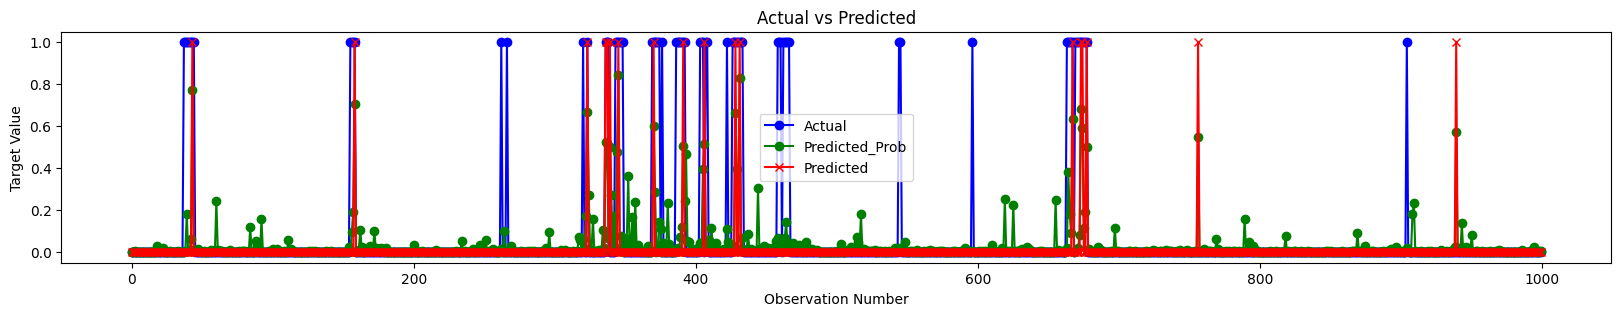

In [59]:
begin_period = 2000
end_period = begin_period + 1000

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(y_big_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(y_test_pred[begin_period:end_period], label='Predicted_Prob', color='green', marker='o')  # 첫 100개 데이터
plt.plot(y_test_pred_binary[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [62]:
## BECKTESTING
test_return = 1.0
temp_return = []
i=0
j=0
while i < len(y_raw_test):
    if y_test_pred[i] > 0.5:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y_raw_test.values[i] < price_threshold : 
            test_return = test_return  * (( X_raw_test['dv7_return_for_backtesting'].iloc[i]- 0.001 -0.0001))
            temp_return.append(X_raw_test['dv7_return_for_backtesting'].iloc[i])
            i = i+10
        else:
            test_return = test_return * (( price_threshold  - 0.001 -0.0001))
            i = i+10
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y_big_test))
print('number of trading:', j)

def calculate_mean(lst):
    if not lst:
        return None  # Handle empty list to avoid division by zero
    return sum(lst) / len(lst)

print('average loss:', calculate_mean(temp_return))
print('min loss:', min(temp_return))


test_return: 1.0607633322661614
len(y_selected_test)): 3729
number of trading: 46
average loss: 1.0001672804355621
min loss: 0.9955824


### SAVE the LGBM model

In [64]:
import lightgbm as lgb
import joblib


coin = 'BTC'
machine_num = '20240107_general_combined2'

scaler_mean = scaler.mean_
scaler_std = np.sqrt(scaler.var_)
np.savez('D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\scaler_params_{}_v{}.npz'.format(coin,machine_num), mean = scaler_mean, std=scaler_std)

# Save the scaler to a file using joblib
joblib.dump(scaler, '.\\trading program\\scaler_{}_v{}.joblib'.format(coin,machine_num))

# Save the trained model to a file
joblib.dump(bst, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_classifier_model_{}_v{}.joblib'.format(coin,machine_num))
print(coin, machine_num)
X_selected_vars_list = X2_selected_df4.columns.tolist()
joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,machine_num))
# X_baseline_vars_list = baseline_X_varlist.columns.tolist()
joblib.dump(baseline_X_varlist, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,machine_num))
# Find common values of A and B
common_values = set(X_selected_vars_list) & set(baseline_X_varlist)

# Get A' (unique values in A not present in B)
baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)
# X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,machine_num))



BTC 20240107_general_combined2


['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v20240107_general_combined2.pkl']

In [ ]:
baseline_X_varlist_2

#### LGBM2 - positive/negative return only

In [244]:
how_many = 128 ########################################################
list1 = importance_df['Feature'].iloc[:how_many].tolist()
# list3 = importance_df['Feature'].iloc[-how_many:].tolist()
# list2 = baseline_X_varlist
combined_list = list(set( list1  )) # +list3 list1 ++ list2

# df5 = df3[df3['return']<1.0000]
df5 = df3[df3['highest_possible_return']>1.001]

X2_selected = df5[combined_list] # 256을 바꾸어가면서 분석하자.
y2 = df5[target_var]  
y2_category = (df5[target_var] > 1.002).astype(int)

print(X2_selected.shape)
test_size_setting = 0.1
val_size_setting = 0.1

_, X_raw_test, y_raw_temp, y_raw_test = train_test_split(df5, y2, test_size=test_size_setting, shuffle = False) 
# X_train, X_test, y_train, y_test = train_test_split(X2_selected, y2_category, test_size=test_size_setting, shuffle=False)

(10006, 128)


In [245]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming your data has features X and target variable y
X_big = X2_selected
y_big = y2_category
print("# of features:", X2_selected.shape[1])

# Decompose the big data into train, val, and test sets
X_big_temp, X_big_test , y_big_temp, y_big_test = train_test_split(X_big, y_big, test_size=test_size_setting, shuffle = False)

# Manipulating the train and validation data
print("Before manipulation. len(X_big_train):", len(X_big_temp))
condition = (y_raw_temp > 1.0015) & (y_raw_temp < 1.0020)
X_big_temp = X_big_temp[~condition]
y_big_temp = y_big_temp[~condition]
print("After manipulation. len(X_big_train):", len(X_big_temp))

X_big_train, X_big_val, y_big_train, y_big_val = train_test_split(X_big_temp, y_big_temp, test_size=val_size_setting, shuffle = False)

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_big_train = scaler.fit_transform(X_big_train)
X_big_val = scaler.transform(X_big_val)
X_big_test = scaler.transform(X_big_test)


# Create LGBM datasets
train_data = lgb.Dataset(X_big_train, label=y_big_train)
val_data = lgb.Dataset(X_big_val, label=y_big_val, reference=train_data)

params = {
    # 'objective': 'regression',  # 회귀 문제
    # 'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
    # 'metric': 'l2',             # Mean Squared Error
    'num_leaves': 150,          # 리프 노드의 최대 수 (mean_leaves에 가깝게 설정) # 100
    'min_data_in_leaf': 50,     # 한 리프에 최소한으로 필요한 레코드 수
    'max_depth': 15,            # 최대 깊이 (max_depth에 맞춤) # 15
    'learning_rate': 0.01,      # 학습률 # 0.05
    'feature_fraction': 0.9,    # 트리를 학습할 때마다 선택할 피처의 비율
    'bagging_fraction': 0.8,    # 트리를 학습할 때마다 선택할 데이터의 비율
    'bagging_freq': 7,          # bagging의 빈도
    'n_estimators': 250     # 총 트리의 수 (number_of_trees에 맞춤)
}

# Train the model with the best hyperparameters
bst = lgb.train(
    {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'},
    train_data,
    num_boost_round=1000,
    valid_sets=[val_data],
    # early_stopping_rounds=50,
    # verbose_eval=10
)


# of features: 128
Before manipulation. len(X_big_train): 9005
After manipulation. len(X_big_train): 8140
[LightGBM] [Info] Number of positive: 1241, number of negative: 6085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32152
[LightGBM] [Info] Number of data points in the train set: 7326, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169397 -> initscore=-1.589909
[LightGBM] [Info] Start training from score -1.589909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

c:\Users\hhkim\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [246]:
# Evaluate the trained model
y_train_pred = bst.predict(X_big_train, num_iteration=bst.best_iteration)
y_val_pred = bst.predict(X_big_val, num_iteration=bst.best_iteration)
y_test_pred = bst.predict(X_big_test, num_iteration=bst.best_iteration)

# Convert predicted probabilities to binary predictions
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate accuracy
train_accuracy = accuracy_score(y_big_train, y_train_pred_binary)
val_accuracy = accuracy_score(y_big_val, y_val_pred_binary)
test_accuracy = accuracy_score(y_big_test, y_test_pred_binary)

# Calculate precision
train_precision = precision_score(y_big_train, y_train_pred_binary)
val_precision = precision_score(y_big_val, y_val_pred_binary)
test_precision = precision_score(y_big_test, y_test_pred_binary)

# calculate recall
# recall = recall_score(y_test, y_pred)
train_recall = recall_score(y_big_train, y_train_pred_binary)
val_recall = recall_score(y_big_val, y_val_pred_binary)
test_recall = recall_score(y_big_test, y_test_pred_binary)

print('==== ACCURACY ====')
print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')
print('==== PRECISION ====')
print(f'Training Precision: {train_precision}')
print(f'Validation Precision: {val_precision}')
print(f'Test Precision: {test_precision}')
print('==== RECALL ====')
print(f'Training recall: {train_recall}')
print(f'Validation recall: {val_recall}')
print(f'Test recall: {test_recall}')

print('==== HOW MANY 1s ====')
print('==== train ====')
print('# of 1s:', sum(y_big_train))
print('# of 1s:', sum(y_train_pred_binary))

print('==== validation ====')
print('# of 1s:', sum(y_big_val))
print('# of 1s:', sum(y_val_pred_binary))

print('==== test ====')
print('# of 1s:', sum(y_big_test))
print('# of 1s:', sum(y_test_pred_binary))

==== ACCURACY ====
Training Accuracy: 0.9369369369369369
Validation Accuracy: 0.8476658476658476
Test Accuracy: 0.8181818181818182
==== PRECISION ====
Training Precision: 0.9534342258440046
Validation Precision: 0.7123287671232876
Test Precision: 0.6888888888888889
==== RECALL ====
Training recall: 0.6599516518936341
Validation recall: 0.33548387096774196
Test recall: 0.28703703703703703
==== HOW MANY 1s ====
==== train ====
# of 1s: 1241
# of 1s: 859
==== validation ====
# of 1s: 155
# of 1s: 73
==== test ====
# of 1s: 216
# of 1s: 90


In [247]:
## BECKTESTING
test_return = 1.0
temp_return = []
i=0
j=0
while i < len(y_big_test):
    if y_test_pred[i] > 0.7:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y_big_test.values[i] < 1.002: 
            test_return = test_return  * (( X_raw_test['dv7_return_for_backtesting'].iloc[i]- 0.001 -0.0001))
            temp_return.append(X_raw_test['dv7_return_for_backtesting'].iloc[i])
            i = i+10
        else:
            test_return = test_return * (( 1.002 - 0.001 -0.0001))
            i = i+10
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y_big_test))
print('number of trading:', j)

def calculate_mean(lst):
    if not lst:
        return None  # Handle empty list to avoid division by zero
    return sum(lst) / len(lst)

print('average loss:', calculate_mean(temp_return))
print('min loss:', min(temp_return))


test_return: 1.011776983415607
len(y_selected_test)): 1001
number of trading: 21
average loss: 1.0016589902696156
min loss: 0.99894154


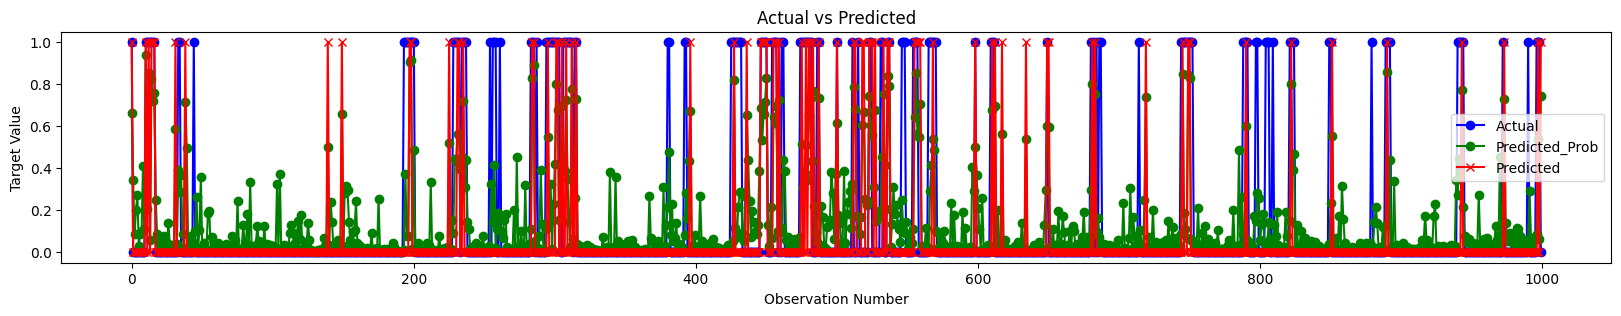

In [127]:
begin_period = 1000
end_period = begin_period + 1000

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(y_big_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(y_test_pred[begin_period:end_period], label='Predicted_Prob', color='green', marker='o')  # 첫 100개 데이터
plt.plot(y_test_pred_binary[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()



##### 최신 데이터로 검증

(3915, 57822)
Test Accuracy: 0.8305203938115331
Test Precision: 0.7582417582417582
Test recall: 0.5418848167539267
==== test ====
# of 1s: 382
# of 1s: 273


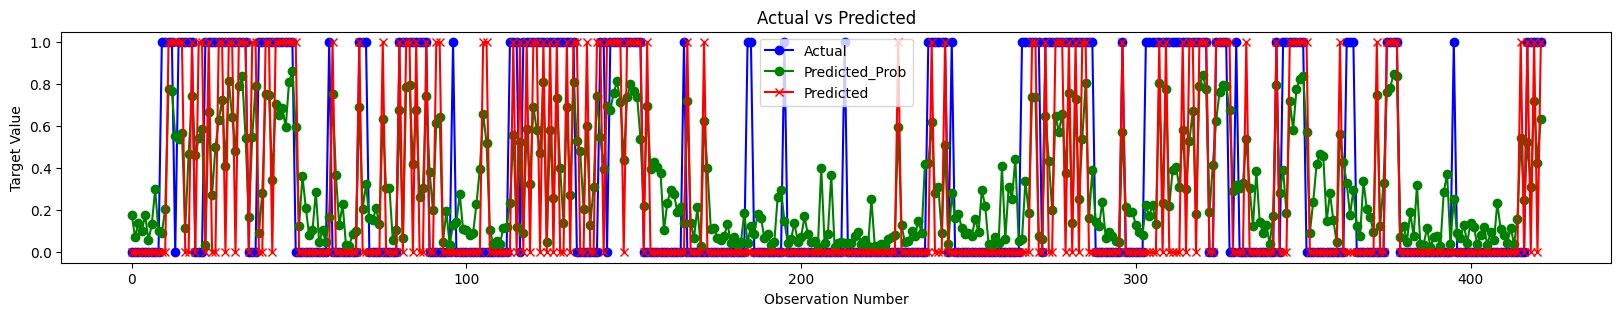

In [248]:
df6 = pd.read_pickle("./output/BTC_baseline_and_nn_features_dv6_202312122122_v7_new.pkl")
# df3_raw = df3.copy()
print(df6.shape)
df6['dv7_return_for_backtesting'] = df6['return'].shift(-10)

df7 = df6[df6['highest_possible_return']>1.001]
# df7 = df6[df6['return']<1.0000]
X2_selected = df7[combined_list] # 256을 바꾸어가면서 분석하자.
y2 = df7[target_var]  
y2_category = (df7[target_var] > 1.002).astype(int)

X2_selected = df7[combined_list] 
y2 = df7[target_var]  
y2_category = (y2 > 1.002).astype(int)
gc.collect()
# Evaluate the trained model

X2_selected_scaled = scaler.transform(X2_selected)
y2_test_pred = bst.predict(X2_selected_scaled, num_iteration=bst.best_iteration)
y2_test_pred_binary = (y2_test_pred > 0.5).astype(int)
test2_accuracy = accuracy_score(y2_category, y2_test_pred_binary)
test2_precision = precision_score(y2_category, y2_test_pred_binary)
test2_recall = recall_score(y2_category, y2_test_pred_binary)

print(f'Test Accuracy: {test2_accuracy}')
print(f'Test Precision: {test2_precision}')
print(f'Test recall: {test2_recall}')

print('==== test ====')
print('# of 1s:', sum(y2_category))
print('# of 1s:', sum(y2_test_pred_binary))

# X2_selected_scaled_df = pd.DataFrame(X2_selected_scaled)
# X2_selected_scaled_df.columns = combined_list
# X2_selected_scaled_df.to_csv("D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\output\\temptemp2.csv")

begin_period = 1000
end_period = begin_period + 1000

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(y2_category.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(y2_test_pred[begin_period:end_period], label='Predicted_Prob', color='green', marker='o')  # 첫 100개 데이터
plt.plot(y2_test_pred_binary[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()



In [249]:

## BECKTESTING
test_return = 1.0
temp_return = []
i=0
j=0
while i < len(y2_category):
    if y2_test_pred[i] > 0.5:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y2.values[i] < 1.002: 
            test_return = test_return  * (( df4['dv7_return_for_backtesting'].iloc[i]- 0.001 -0.0001))
            temp_return.append(df4['dv7_return_for_backtesting'].iloc[i])
            i = i+1
        else:
            test_return = test_return * (( 1.002 - 0.001 -0.0001))
            i = i+1
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y2_category))
print('number of trading:', j)


def calculate_mean(lst):
    if not lst:
        return None  # Handle empty list to avoid division by zero
    return sum(lst) / len(lst)

print('average loss:', calculate_mean(temp_return))
print('min loss:', min(temp_return))


test_return: 1.1238252038479788
len(y_selected_test)): 1422
number of trading: 273
average loss: 1.0000510170604244
min loss: 0.99407846


### 과거 및 최신 데이터를 모두 사용해서 train/val/test 를 만들어서 모델 만들고 테스트해보자.

##### SAVE the LGBM model - positive return only

In [226]:
import lightgbm as lgb
import joblib

coin = 'BTC'
machine_num = '20231228_positive'

# scaler_mean = scaler.mean_
# scaler_std = np.sqrt(scaler.var_)
# np.savez('D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\scaler_params_{}_v{}.npz'.format(coin,machine_num), mean = scaler_mean, std=scaler_std)

# Save the scaler to a file using joblib
joblib.dump(scaler, '.\\trading program\\scaler_{}_v{}.joblib'.format(coin,machine_num))

# Save the trained model to a file
joblib.dump(bst, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_classifier_model_{}_v{}.joblib'.format(coin,machine_num))
X_selected_vars_list = X2_selected.columns.tolist()
joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,machine_num))
X_baseline_vars_list = X_baseline.columns.tolist()
joblib.dump(X_baseline_vars_list, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,machine_num))
# Find common values of A and B
common_values = set(X_selected_vars_list) & set(X_baseline_vars_list)

# Get A' (unique values in A not present in B)
baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)
# X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,machine_num))



['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v20231228_positive.pkl']

## M1: XGBoost (0.438) => 당분간 활용 X

In [21]:
# # XGBoost 모델 생성 및 피팅
# model_1 = XGBRegressor(tree_method='hist',enable_categorical=True)
# model_1.fit(X_train, y_train)

# # XGBoost 모델 생성 및 피팅
# # model_1_baseline= XGBRegressor(tree_method='hist',enable_categorical=True)
# # model_1_baseline.fit(X_baseline_train, y_baseline_train)


In [22]:
# # 피쳐 중요도(feature importance)를 기반으로 상위 20개 피쳐 선택

# num_features_rf = 128
# feature_importances = pd.Series(model_1.feature_importances_, index=X_train.columns)
# top_n_features = feature_importances.nlargest(num_features_rf).index.tolist()
# print(top_n_features)
# # 상위 20개 피쳐만 선택
# # X_selected = X[top_n_features]
# X_selected = X[top_n_features]

# gc.collect()

In [23]:
# X_selected_train, X_selected_test, y_selected_train, y_selected_test = train_test_split(X_selected, y, test_size=0.05, shuffle = False)


In [24]:
# begin_period = 0
# end_period = begin_period + 500

# import matplotlib.pyplot as plt

# # y_selected_train
# XGB_selected_predictions_train = model_1.predict(X_test)
# # y_selected_pred = model_1.predict(X_train, num_iteration=model_1.best_iteration)

# # 실제 값과 예측 값 비교를 위한 그래프
# plt.figure(figsize=(20, 6))
# plt.plot(y_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
# plt.plot(XGB_selected_predictions_train[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
# # plt.plot(y_selected_train.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
# # plt.plot(y_selected_train_pred[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
# plt.title('Actual vs Predicted')
# plt.xlabel('Observation Number')
# plt.ylabel('Target Value')
# plt.legend()
# plt.show()


## LGBM only

In [25]:
# def my_lgbm(X_category_train, y_category_train, selected_features):

import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
import pandas as pd


In [26]:
# Assuming you have features (X) and labels (y)
X_train, X_val, y_train, y_val = train_test_split(X_category_train, y_category_train, test_size=val_size_setting, shuffle = False)


In [28]:
## To find important 128 selected X variables ##

# Create LGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    # 'objective': 'regression',  # 회귀 문제
    # 'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
    # 'metric': 'l2',             # Mean Squared Error
    'num_leaves': 100,          # 리프 노드의 최대 수 (mean_leaves에 가깝게 설정) # 100
    'min_data_in_leaf': 50,     # 한 리프에 최소한으로 필요한 레코드 수
    'max_depth': 30,            # 최대 깊이 (max_depth에 맞춤) # 15
    'learning_rate': 0.01,      # 학습률 # 0.05
    'feature_fraction': 0.9,    # 트리를 학습할 때마다 선택할 피처의 비율
    'bagging_fraction': 0.8,    # 트리를 학습할 때마다 선택할 데이터의 비율
    'bagging_freq': 7,          # bagging의 빈도
    'n_estimators': 105        # 총 트리의 수 (number_of_trees에 맞춤)
    
}

# Loaded best parameters: {'bagging_fraction': 0.8, 
#                          'bagging_freq': 7, 
#                          'feature_fraction': 0.9, 
#                          'learning_rate': 0.01, 
#                          'max_depth': 30, 
#                          'min_data_in_leaf': 50, 
#                          'n_estimators': 105, 
#                          'num_leaves': 100}


# Train the model with the best hyperparameters
bst = lgb.train(
    {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'},
    train_data,
    num_boost_round=1000,
    valid_sets=[val_data],
    # early_stopping_rounds=50,
    # verbose_eval=10
)

# Get feature importances
feature_importance = bst.feature_importance(importance_type='split')
# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Select the top 128 features
top_features = feature_importance_df.head(128)['Feature'].tolist()
# Display the top features
print("Top 128 Features:")
print(top_features)

[LightGBM] [Info] Number of positive: 929, number of negative: 11308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.303043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5572588
[LightGBM] [Info] Number of data points in the train set: 12237, number of used features: 21854
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075917 -> initscore=-2.499157
[LightGBM] [Info] Start training from score -2.499157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Top 128 Features:
['dv6_highest_possible_return_nn1_all_nn_m_p1_mean', 'dv6_highest_possible_return_nn8_all_nn_m_p1_mean', 'dv6_highest_possible_return_nn1_high5_nn_m_mean', 'dv6_highest_possible_return

In [29]:
# Evaluate the trained model
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
y_val_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
y_test_pred = bst.predict(X_category_test, num_iteration=bst.best_iteration)

# Convert predicted probabilities to binary predictions
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
val_accuracy = accuracy_score(y_val, y_val_pred_binary)
test_accuracy = accuracy_score(y_category_test, y_test_pred_binary)

# Calculate precision
train_precision = precision_score(y_train, y_train_pred_binary)
val_precision = precision_score(y_val, y_val_pred_binary)
test_precision = precision_score(y_category_test, y_test_pred_binary)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

print(f'Training Precision: {train_precision}')
print(f'Validation Precision: {val_precision}')
print(f'Test Precision: {test_precision}')

Training Accuracy: 0.9501511808449783
Validation Accuracy: 0.9367647058823529
Test Accuracy: 0.7683653209794837
Training Precision: 1.0
Validation Precision: 0.9545454545454546
Test Precision: 0.863013698630137


In [30]:
X_selected = X[top_features]

X_selected_category_train, X_selected_category_test, y_selected_category_train, y_selected_category_test = train_test_split(X_selected, y_category, test_size=test_size_setting, shuffle = False) 
X_selected_category_train2, X_selected_category_val, y_selected_category_train2, y_selected_category_val = train_test_split(X_selected_category_train, y_selected_category_train, test_size=val_size_setting, shuffle = False) 
# Create LGBM datasets
train_data = lgb.Dataset(X_selected_category_train2, label=y_selected_category_train2)
val_data = lgb.Dataset(X_selected_category_val, label=y_selected_category_val, reference=train_data)


In [ ]:
# ## GRID SEARCH to find best hyperparameters ## 

# # Set a range of hyperparameters for tuning
# param_grid = {
#     'num_leaves': [50, 100, 200],
#     'learning_rate': [0.005, 0.01, 0.02],
#     'feature_fraction': [0.8, 0.9, 1.0],
#     'bagging_fraction': [0.7, 0.8, 0.9, 1.0],
#     'bagging_freq': [3, 5, 7],
#     'max_depth': [10, 15, 30],
#     'n_estimators': [50, 105, 150],
#     'min_data_in_leaf': [50], 
# }

# lgb_classifier = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', boosting_type='gbdt', verbose=0)
# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(lgb_classifier, param_grid, scoring='accuracy', cv=3)
# grid_search.fit(X_selected_category_train2, y_selected_category_train2)
# # Get the best hyperparameters
# best_params = grid_search.best_params_



In [29]:
# import json
# file_path = 'best_params.json'
# with open(file_path, 'w') as file:
#     json.dump(best_params, file)

# print(f"Best parameters saved to {file_path}")

Best parameters saved to best_params.json


In [30]:
# # Load the best_params_ from the JSON file
# import json
# file_path = 'best_params.json'

# with open(file_path, 'r') as file:
#     loaded_best_params = json.load(file)

# print("Loaded best parameters:", loaded_best_params)

Loaded best parameters: {'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 30, 'min_data_in_leaf': 50, 'n_estimators': 105, 'num_leaves': 100}


In [32]:
# Train the model with the best hyperparameters
bst = lgb.train(
    {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'},
    train_data,
    num_boost_round=1000,
    valid_sets=[val_data],
    # early_stopping_rounds=50,
    # verbose_eval=10
)

# Evaluate the trained model
y_train_pred = bst.predict(X_selected_category_train2, num_iteration=bst.best_iteration)
y_val_pred = bst.predict(X_selected_category_val, num_iteration=bst.best_iteration)
y_test_pred = bst.predict(X_selected_category_test, num_iteration=bst.best_iteration)

# Convert predicted probabilities to binary predictions
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate accuracy
train_accuracy = accuracy_score(y_selected_category_train2, y_train_pred_binary)
val_accuracy = accuracy_score(y_selected_category_val, y_val_pred_binary)
test_accuracy = accuracy_score(y_selected_category_test, y_test_pred_binary)

# Calculate precision
train_precision = precision_score(y_selected_category_train2, y_train_pred_binary)
val_precision = precision_score(y_selected_category_val, y_val_pred_binary)
test_precision = precision_score(y_selected_category_test, y_test_pred_binary)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

print(f'Training Precision: {train_precision}')
print(f'Validation Precision: {val_precision}')
print(f'Test Precision: {test_precision}')

c:\Users\hhkim\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 929, number of negative: 11308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 12237, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075917 -> initscore=-2.499157
[LightGBM] [Info] Start training from score -2.499157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training Accuracy: 0.9446759826754924
Validation Accuracy: 0.9404411764705882
Test Accuracy: 0.7782925215089345
Training Precision: 0.9846153846153847
Validation Precision: 0.8571428571428571
Test Precision: 0.7982456140350878


In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

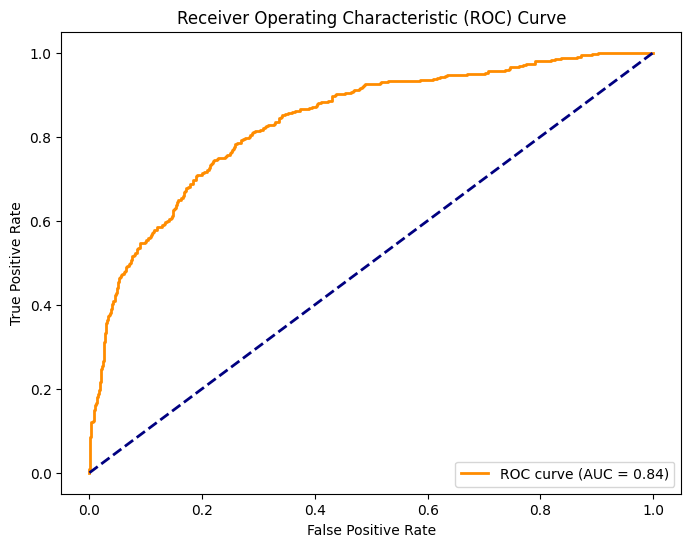

In [34]:
# Display ROC curve
fpr, tpr, _ = roc_curve(y_selected_category_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

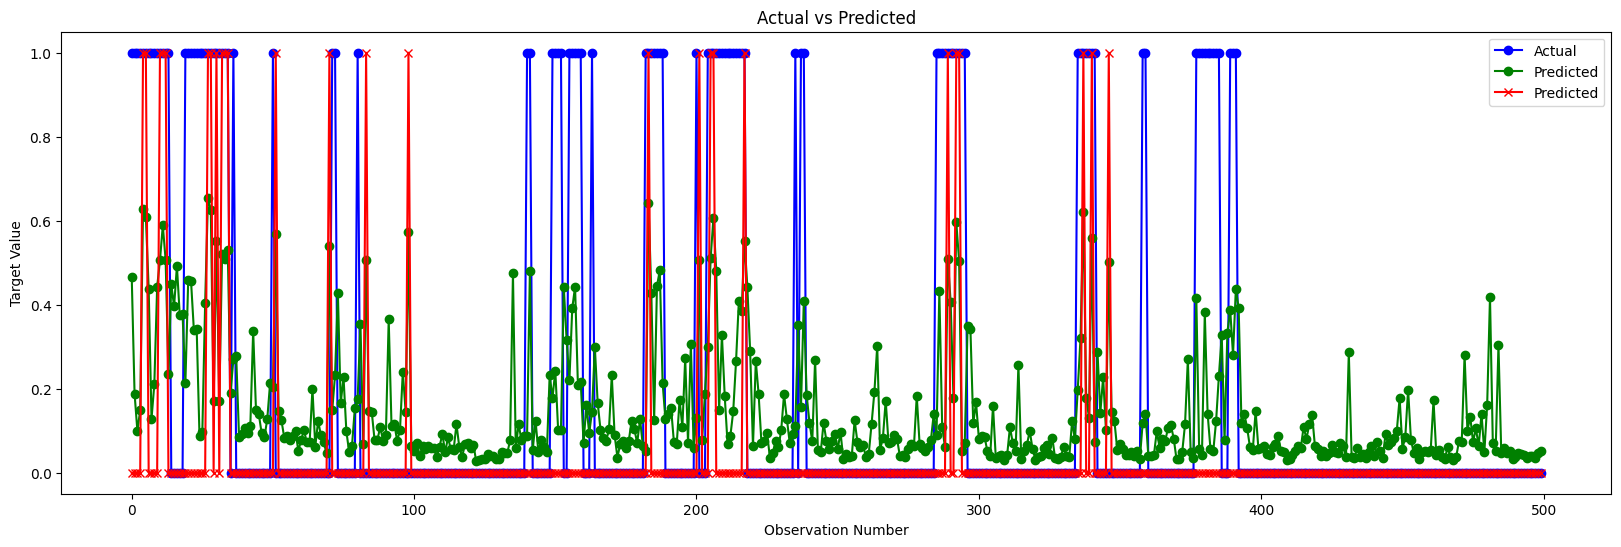

In [35]:
begin_period = 0
end_period = begin_period + 500

import matplotlib.pyplot as plt

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(20, 6))
plt.plot(y_selected_category_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(y_test_pred[begin_period:end_period], label='Predicted', color='green', marker='o')  # 첫 100개 데이터
plt.plot(y_test_pred_binary[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
# plt.plot(y_selected_train.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
# plt.plot(y_selected_train_pred[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()



In [37]:
## BECKTESTING
test_return = 1.0
i=0
j=0
while i < len(y_selected_category_test):
    if y_test_pred_binary[i] == 1:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y_test.values[i] < 1.002: 
            test_return = test_return  * (( X_raw_test['return'].iloc[i]- 0.001 -0.0001))
            i = i+1
        else:
            test_return = test_return * (( 1.002 - 0.001 -0.0001))
            i = i+1
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y_category_test))
print('number of trading:', j)

test_return: 1.0411543153308276
len(y_selected_test)): 1511
number of trading: 114


In [41]:
import lightgbm as lgb
import joblib

# Save the trained model to a file
joblib.dump(bst, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_classifier_model_{}_v{}.joblib'.format(coin,vn))

X_selected_vars_list = X_selected_category_test.columns.tolist()
joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,vn))
X_baseline_vars_list = X_baseline.columns.tolist()
joblib.dump(X_baseline_vars_list, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,vn))
# Find common values of A and B
common_values = set(X_selected_vars_list) & set(X_baseline_vars_list)

# Get A' (unique values in A not present in B)
baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)
# X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,vn))



['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v202312122122_1.pkl']

In [ ]:
# import lightgbm as lgb
# import joblib
# joblib.dump(lgbm_selected_classifier_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_classifier_model_{}_v{}.joblib'.format(coin,vn))

# # Save the model
# # joblib.dump(xgb_model, 'xgboost_model.pkl')
# # lgbm_selected_model.save_model('D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model.txt')

# # joblib.dump(lgbm_selected_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model.txt')
# # joblib.dump(cat_model, 'cat_model.pkl')

# gc.collect()

# X_selected_vars_list = X_selected_category_test.columns.tolist()
# joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,vn))
# X_baseline_vars_list = X_baseline.columns.tolist()
# joblib.dump(X_baseline_vars_list, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,vn))
# # Find common values of A and B
# common_values = set(X_selected_vars_list) & set(X_baseline_vars_list)

# # Get A' (unique values in A not present in B)
# baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)
# # X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
# joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,vn))

['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v202312122122_1.pkl']

In [112]:
# import pandas as pd
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor, LGBMClassifier
# from sklearn.model_selection import train_test_split
# import lightgbm as lgb

# lgbm_classifier_model = LGBMClassifier()
# lgbm_classifier_model.fit(X_category_train, y_category_train)

# # lgbm_classifier_selected_model = LGBMClassifier()
# # lgbm_classifier_selected_model.fit(X_selected_train, y_category_train)

# # Get feature importance scores
# feature_importance = lgbm_classifier_model.feature_importances_
# top_features_indices = np.argsort(feature_importance)[::-1][:128]
# top_features_names = X_category_train.columns[top_features_indices]  # Replace with your actual column names

# # Display or use the selected features
# print("Top 128 features:")
# print(top_features_names)

# X_selected = X[top_features_names]


[LightGBM] [Info] Number of positive: 1035, number of negative: 12562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.246235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5572597
[LightGBM] [Info] Number of data points in the train set: 13597, number of used features: 21854
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076120 -> initscore=-2.496275
[LightGBM] [Info] Start training from score -2.496275
Top 128 features:
Index(['dv6_highest_possible_return_nn1_all_nn_m_p1_mean',
       'dv6_highest_possible_return_nn1_high5_nn_m_mean',
       'dv6_highest_possible_return_nn1_high5_abs_nn_m_mean',
       'dv6_highest_possible_return_nn1_high_low_gap_m_p1_mean',
       'dv6_highest_possible_return_nn1_high_low_gap_450_m_p1_mean',
       'dv6_highest_possible_return_nn4_BB_width_w40_m_p1_std',
       'dv6_highest_possible_return_nn4_high5_nn_m_std',
       'dv6_highest_possible_return_nn4_all_nn_m_

In [116]:
# X_selected_category_train, X_selected_category_test, y_selected_category_train, y_selected_category_test = train_test_split(X_selected, y_category, test_size=test_size_setting, shuffle = False) 

# lgbm_selected_classifier_model = LGBMClassifier()
# lgbm_selected_classifier_model.fit(X_selected_category_train, y_selected_category_train)


[LightGBM] [Info] Number of positive: 1035, number of negative: 12562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 13597, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076120 -> initscore=-2.496275
[LightGBM] [Info] Start training from score -2.496275


LGBMClassifier()

In [117]:
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# LightGBM 모델 생성 및 피팅
# lgbm_model = LGBMRegressor()
# lgbm_model.fit(X_train, y_train)

# lgbm_baseline_model = LGBMRegressor()
# lgbm_baseline_model.fit(X_baseline_train, y_baseline_train)
# lgbm_selected_model = LGBMRegressor()
# lgbm_selected_model.fit(X_selected_train, y_selected_train)

# # 두 모델의 예측값의 평균으로 최종 예측 생성
# # lgbm_predictions = lgbm_model.predict(X_test)
# # lgbm_baseline_predictions = lgbm_baseline_model.predict(X_baseline_test)
# # 두 모델의 예측값의 평균으로 최종 예측 생성
# lgbm_selected_predictions = lgbm_selected_model.predict(X_selected_test)

# X_selected_train, X_selected_test, y_selected_train, y_selected_test = train_test_split(X_selected, y, test_size=0.1, shuffle = False)
# X_selected_train, X_selected_val, y_selected_train, y_selected_val = train_test_split(X_selected_train, y_selected_train, test_size = 0.1, shuffle = False)

# lgbm_selected_model = LGBMRegressor()
# lgbm_selected_model.fit(X_selected_train, y_selected_train)

# # LightGBM 데이터셋으로 변환
# lgb_train = lgb.Dataset(X_selected_train, y_selected_train)
# lgb_eval = lgb.Dataset(X_selected_val, y_selected_val)

# params = {
#     'objective': 'regression',  # 회귀 문제
#     'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
#     'metric': 'l2',             # Mean Squared Error
#     'num_leaves': 100,          # 리프 노드의 최대 수 (mean_leaves에 가깝게 설정) # 100
#     'min_data_in_leaf': 50,     # 한 리프에 최소한으로 필요한 레코드 수
#     'max_depth': 15,            # 최대 깊이 (max_depth에 맞춤) # 15
#     'learning_rate': 0.01,      # 학습률 # 0.05
#     'feature_fraction': 0.9,    # 트리를 학습할 때마다 선택할 피처의 비율
#     'bagging_fraction': 0.8,    # 트리를 학습할 때마다 선택할 데이터의 비율
#     'bagging_freq': 5,          # bagging의 빈도
#     'n_estimators': 105        # 총 트리의 수 (number_of_trees에 맞춤)
    
# }

# print('Starting training...')
# gbm = lgb.train(params,
#     lgb_train,
#     num_boost_round=500,
#     valid_sets=lgb_eval)
#     # early_stopping_rounds=50)

# # 모델 예측
# print('Starting predicting...')

# # 모델 평가0
# # y_train_pred = gbm.predict(X_selected_train, num_iteration=gbm.best_iteration)
# # print('TRAIN SET1: The RMSPE of prediction is:', rmspe(y_train, y_train_pred))

# # # 모델 평가1
# y_selected_pred = gbm.predict(X_selected_test, num_iteration=gbm.best_iteration)
# # print('TEST SET1: The RMSPE of prediction is:', rmspe(y_test, y_pred))


# # # RMSPE 계산
# # rmspe_value = rmspe(y_test, lgbm_predictions)
# # print(f"LGBM RMSPE: {rmspe_value}") # 0.38122685147954977
# # RMSPE 계산
# # rmspe_selected_value = rmspe(y_selected_test, lgbm_selected_predictions)
# # print(f"LGBM selected RMSPE: {rmspe_selected_value}") # 0.38122685147954977

# LGBM_mae = mean_absolute_error(y_selected_test, y_selected_pred)
# print(f"LGBM MAE : {LGBM_mae}")
# # LGBM_baseline_mae = mean_absolute_error(y_baseline_test, lgbm_baseline_predictions)
# # print(f"LGBM baseline MAE: {LGBM_baseline_mae}")
# # LGBM_selected_mae = mean_absolute_error(y_selected_test, lgbm_selected_predictions)
# # print(f"LGBM selected MAE: {LGBM_selected_mae}")
# gc.collect()


In [118]:
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# y_pred_proba = lgbm_classifier_model.predict_proba(X_category_test)[:, 1]
# y_pred_binary = lgbm_classifier_model.predict(X_category_test)
# accuracy = accuracy_score(y_category_test, y_pred_binary)
# precision = precision_score(y_category_test, y_pred_binary)

# y_selected_pred_proba = lgbm_selected_classifier_model.predict_proba(X_selected_category_test)[:, 1]
# y_selected_pred_binary = lgbm_selected_classifier_model.predict(X_selected_category_test)
# accuracy_selected = accuracy_score(y_selected_category_test, y_selected_pred_binary)
# precision_selected = precision_score(y_selected_category_test, y_selected_pred_binary)

# print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision: {precision:.4f}')

# print(f'accuracy_selected: {accuracy_selected:.4f}')
# print(f'precision_selected: {precision_selected:.4f}')

Accuracy: 0.8107
Precision: 0.7671
accuracy_selected: 0.8048
precision_selected: 0.7015


In [33]:
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

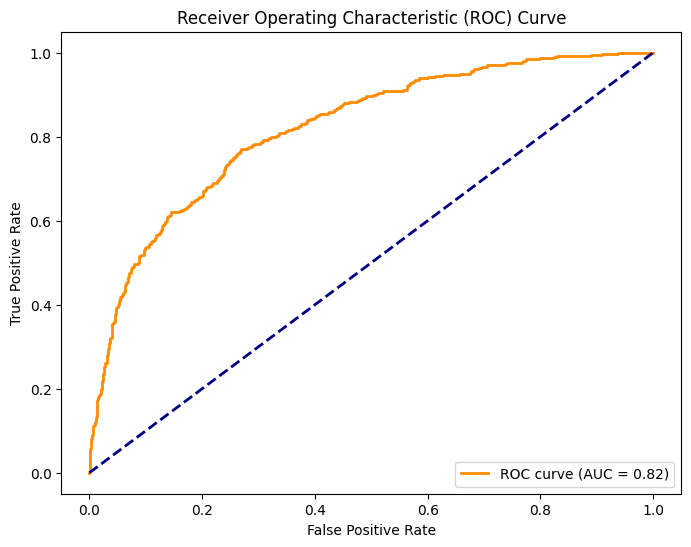

In [86]:
# Display ROC curve
fpr, tpr, _ = roc_curve(y_selected_category_test, y_selected_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

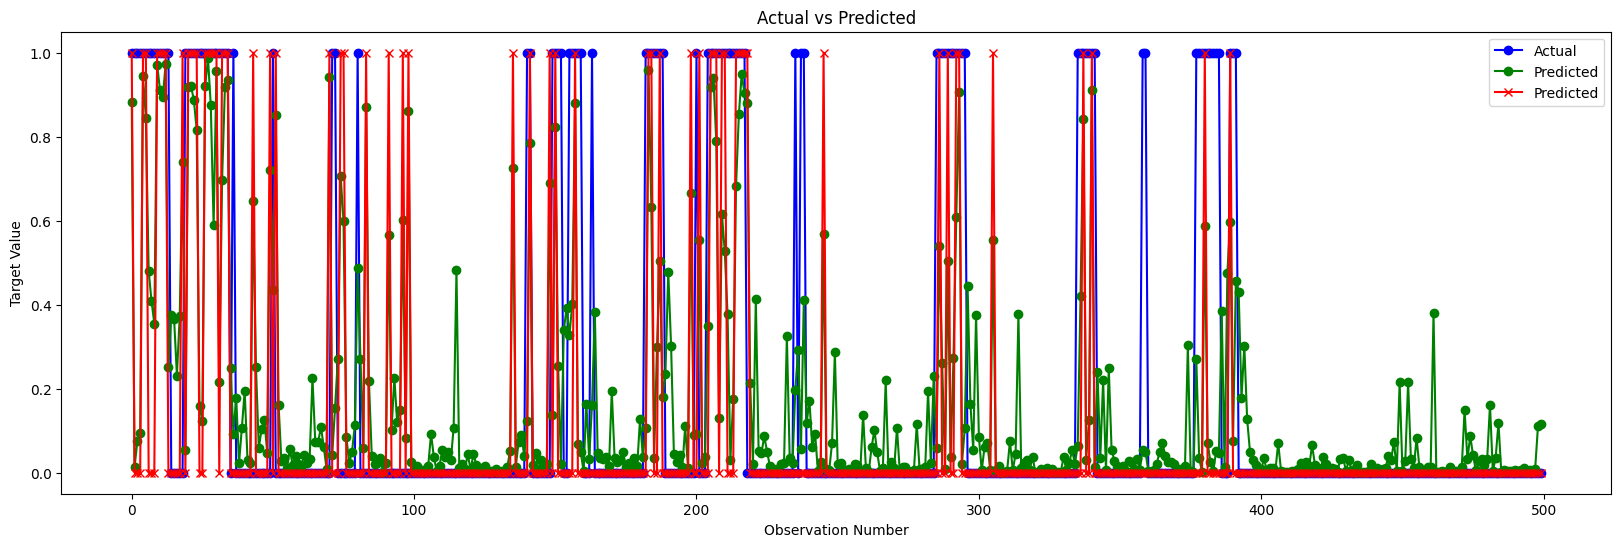

In [119]:
begin_period = 0
end_period = begin_period + 500

import matplotlib.pyplot as plt

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(20, 6))
plt.plot(y_selected_category_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(y_selected_pred_proba[begin_period:end_period], label='Predicted', color='green', marker='o')  # 첫 100개 데이터
plt.plot(y_selected_pred_binary[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
# plt.plot(y_selected_train.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
# plt.plot(y_selected_train_pred[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()



In [122]:
## BECKTESTING
test_return = 1.0
i=0
j=0
while i < len(y_selected_pred_binary):
    if y_selected_pred_binary[i] == 1:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y_test.values[i] < 1.002: 
            test_return = test_return  * (( X_raw_test['return'].iloc[i]- 0.001 -0.0001))
            i = i+10
        else:
            test_return = test_return * (( 1.002 - 0.001 -0.0001))
            i = i+10
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y_category_test))
print('number of trading:', j)

test_return: 0.9665679279563394
len(y_selected_test)): 1511
number of trading: 75


In [35]:
import lightgbm as lgb
import joblib
joblib.dump(lgbm_selected_classifier_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_classifier_model_{}_v{}.joblib'.format(coin,vn))

# Save the model
# joblib.dump(xgb_model, 'xgboost_model.pkl')
# lgbm_selected_model.save_model('D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model.txt')

# joblib.dump(lgbm_selected_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model.txt')
# joblib.dump(cat_model, 'cat_model.pkl')

gc.collect()

X_selected_vars_list = X_selected_category_test.columns.tolist()
joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,vn))
X_baseline_vars_list = X_baseline.columns.tolist()
joblib.dump(X_baseline_vars_list, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,vn))
# Find common values of A and B
common_values = set(X_selected_vars_list) & set(X_baseline_vars_list)

# Get A' (unique values in A not present in B)
baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)
# X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,vn))

['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v202312122122_1.pkl']

In [280]:
begin_period = 0
end_period = begin_period + 500

In [ ]:
import matplotlib.pyplot as plt

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(18, 6))
plt.plot(y_baseline_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(lgbm_baseline_predictions[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [53]:
## BECKTESTING

test_return = 1.0
i=0
j=0
while i < len(y_baseline_test):
    if lgbm_baseline_predictions[i] > 1.0020:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y_baseline_test.values[i] < lgbm_baseline_predictions[i]: 
            test_return = test_return  * (( X_baseline_test['return'].iloc[i]- 0.001  - 0.0005))
            i = i+10
        else:
            test_return = test_return * (( lgbm_baseline_predictions[i] - 0.001 - 0.0005))
            i = i+10
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y_selected_test))
print('number of trading:', j)

test_return: 0.9914859836446698
len(y_selected_test)): 243
number of trading: 2


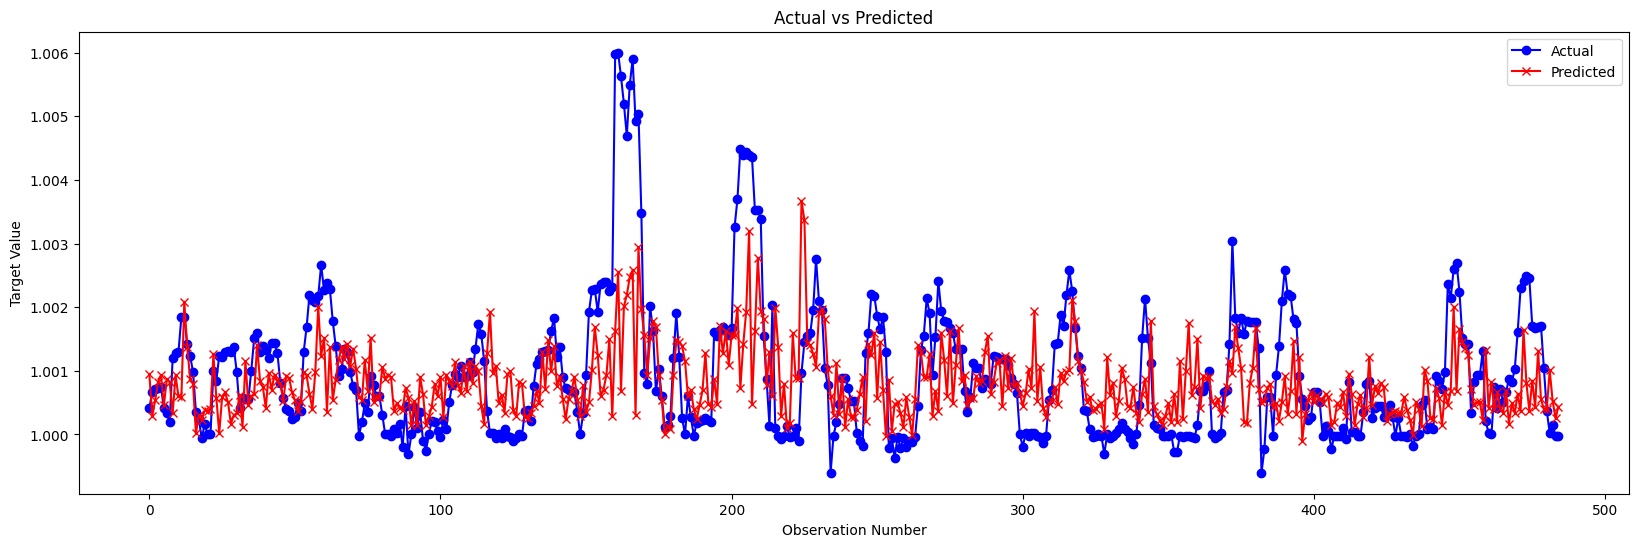

In [296]:
import matplotlib.pyplot as plt

# y_selected_train
# lgbm_selected_predictions_train = gbm.predict(X_selected_train)
# y_selected_train_pred = gbm.predict(X_selected_train, num_iteration=gbm.best_iteration)
lgbm_selected_pred = lgbm_selected_model.predict(X_selected_test)


# y_selected_pred

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(20, 6))
plt.plot(y_selected_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(lgbm_selected_pred[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
# plt.plot(y_selected_train.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
# plt.plot(y_selected_train_pred[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [124]:
## BECKTESTING

test_return = 1.0
i=0
j=0
while i < len(y_selected_test):
    if y_selected_pred[i] > 1.0025:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y_selected_test.values[i] < y_selected_pred[i]: 
            test_return = test_return  * (( X_test['return'].iloc[i]- 0.001 -0.0001))
            i = i+1
        else:
            test_return = test_return * (( y_selected_pred[i] - 0.001 -0.0001))
            i = i+1
    else:
        i = i+1

print("test_return:", test_return)
print('len(y_selected_test)):', len(y_selected_test))
print('number of trading:', j)

test_return: 1.0002053499657484
len(y_selected_test)): 485
number of trading: 5


## 모델 저장하기

In [39]:
import lightgbm as lgb
import joblib

In [40]:
joblib.dump(lgbm_selected_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model_{}_v{}.joblib'.format(coin,vn))
joblib.dump(lgbm_baseline_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_baseline_model_{}_v{}.joblib'.format(coin,vn))

# Save the model
# joblib.dump(xgb_model, 'xgboost_model.pkl')
# lgbm_selected_model.save_model('D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model.txt')

# joblib.dump(lgbm_selected_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model.txt')
# joblib.dump(cat_model, 'cat_model.pkl')

gc.collect()


135

In [41]:
X_selected_vars_list = X_selected_train.columns.tolist()
joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,vn))

['.\\trading program\\X_selected_vars_list_BTC_v10_5000_2.pkl']

In [42]:
X_baseline_vars_list = X_baseline.columns.tolist()
joblib.dump(X_baseline_vars_list, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,vn))

['.\\trading program\\X_baseline_vars_list_BTC_v10_5000_2.pkl']

In [43]:
# Find common values of A and B
common_values = set(X_selected_vars_list) & set(X_baseline_vars_list)

# Get A' (unique values in A not present in B)
baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)

In [44]:
# X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,vn))

['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v10_5000_2.pkl']

## M2: XGBoost + LGBM 앙상블 (0.381)

In [23]:
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# XGBoost 모델 생성 및 피팅
xgb_model = model_1
if xgb_model is None:
    xgb_model = XGBRegressor(tree_method='hist')
    xgb_model.fit(X_train, y_train)

# XGBoost baseline 모델 생성 및 피팅
xgb_baseline_model = model_1_baseline
if xgb_baseline_model is None:
    xgb_baseline_model = XGBRegressor(tree_method='hist')
    xgb_baseline_model.fit(X_baseline_train, y_baseline_train)

# LightGBM 모델 생성 및 피팅
if lgbm_model is  None:
    lgbm_model = LGBMRegressor()
    lgbm_model.fit(X_train, y_train)
if lgbm_baseline_model is  None:
    lgbm_baseline_model = LGBMRegressor()
    lgbm_baseline_model.fit(X_baseline_train, y_baseline_train)

# # 두 모델의 피쳐 중요도 계산
# xgb_feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
# lgbm_feature_importances = pd.Series(lgbm_model.feature_importances_ / sum(lgbm_model.feature_importances_), index=X.columns)

# # 두 모델의 평균 피쳐 중요도 계산
# average_feature_importances = (xgb_feature_importances + lgbm_feature_importances) / 2

# # 상위 n (=100) 개 피쳐 선택
# n = 100
# top_features = average_feature_importances.nlargest(n).index.tolist()

# # 선택된 피쳐로 데이터셋 준비
# X_selected_train = X_train[top_features]
# X_selected_test = X_test[top_features]

# # 선택된 피쳐로 모델 재피팅
# xgb_model.fit(X_selected_train, y_train)
# lgbm_model.fit(X_selected_train, y_train)

# 두 모델의 예측값의 평균으로 최종 예측 생성
xgb_predictions = xgb_model.predict(X_test)
lgbm_predictions = lgbm_model.predict(X_test)
Esem_XGBoost_LGBM_predictions = (xgb_predictions + lgbm_predictions) / 2


# 두 모델의 예측값의 평균으로 최종 예측 생성
xgb_baseline_predictions = xgb_baseline_model.predict(X_baseline_test)
lgbm_baseline_predictions = lgbm_baseline_model.predict(X_baseline_test)
Esem_XGBoost_LGBM_baseline_predictions = (xgb_baseline_predictions + lgbm_baseline_predictions) / 2



In [25]:
# RMSPE 계산
rmspe_value = rmspe(y_test, Esem_XGBoost_LGBM_predictions)
print(f"RMSPE_M2: {rmspe_value}") # 0.38122685147954977

# RMSPE 계산
rmspe_baseline_value = rmspe(y_baseline_test, Esem_XGBoost_LGBM_baseline_predictions)
print(f"RMSPE_M2_baseline: {rmspe_baseline_value}") # 0.38122685147954977


Esem_XGBoost_LGBM_mae = mean_absolute_error(y_test, Esem_XGBoost_LGBM_predictions)
print(f"Esem_XGBoost_LGBM MAE : {Esem_XGBoost_LGBM_mae}")

Esem_XGBoost_LGBM_baseline_mae = mean_absolute_error(y_baseline_test, Esem_XGBoost_LGBM_baseline_predictions)
print(f"Esem_XGBoost_LGBM baseline MAE: {Esem_XGBoost_LGBM_baseline_mae}")

RMSPE_M2: 11435.84551230889
RMSPE_M2_baseline: 26347.687180682038
Esem_XGBoost_LGBM MAE : 0.0004267001050881361
Esem_XGBoost_LGBM baseline MAE: 0.0009110926330418484


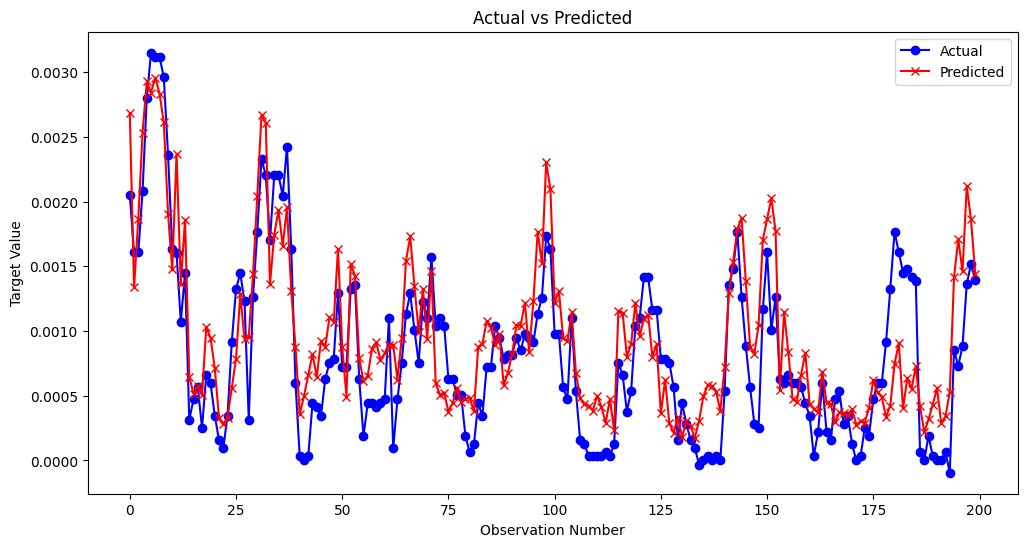

In [26]:
import matplotlib.pyplot as plt

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(12, 6))

begin_period = 500
end_period = begin_period + 200

plt.plot(y_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(Esem_XGBoost_LGBM_predictions[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()


## M1(2): CatBoost only

In [291]:
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# # CatBoost 모델 생성 및 피팅
# cat_model = CatBoostRegressor(verbose=0)
# cat_model.fit(X_train, y_train)

# CatBoost 모델 생성 및 피팅
cat_selected_model = CatBoostRegressor(verbose=0)
cat_selected_model.fit(X_train, y_train)

# cat_preds = cat_model.predict(X_test)
cat_selected_pred = cat_selected_model.predict(X_test)

# # RMSPE 계산
# final_rmspe = rmspe(y_test, cat_preds)
# print(f"CatBoost RMSPE: {final_rmspe}")

# # RMSPE 계산
# final_baseline_rmspe = rmspe(y_baseline_test, cat_baseline_preds)
# print(f"CatBoost baseline RMSPE: {final_baseline_rmspe}")

CatBoost_mae = mean_absolute_error(y_test, cat_selected_pred)
print(f"CatBoost MAE : {CatBoost_mae}")

# CatBoost_baseline_mae = mean_absolute_error(y_baseline_test, cat_baseline_preds)
# print(f"CatBoost baseline MAE: {CatBoost_baseline_mae}")

CatBoost MAE : 0.0006601169086701519


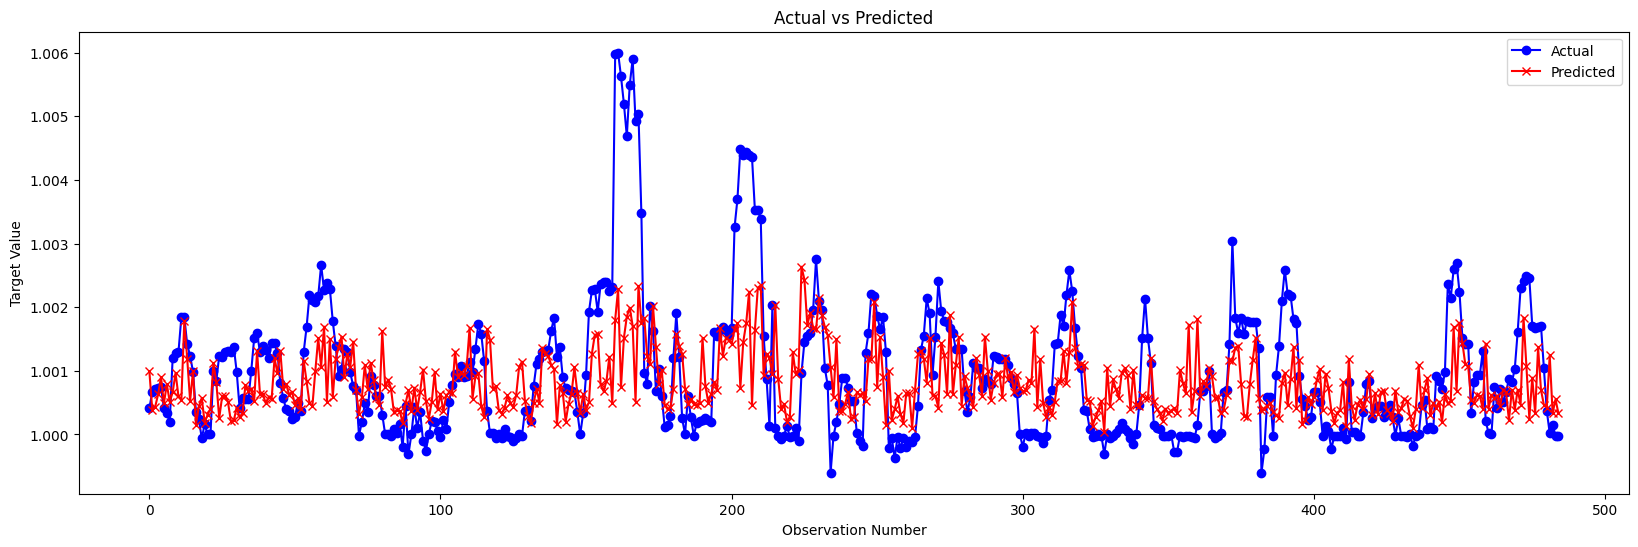

In [292]:
import matplotlib.pyplot as plt

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(20, 6))

begin_period = 0
end_period = begin_period + 500

plt.plot(y_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(cat_selected_pred[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()


## M3: XGBoost + LGBM + CatBoost (0.366)
0.36598857886196107

In [282]:
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# XGBoost 모델 생성 및 피팅
# if xgb_model is  None:
xgb_model = XGBRegressor(tree_method='hist')
xgb_model.fit(X_selected_train, y_selected_train)

# LightGBM 모델 생성 및 피팅
# if lgbm_model is  None:
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_selected_train, y_selected_train)

# CatBoost 모델 생성 및 피팅
# if cat_model is  None:
cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_selected_train, y_selected_train)

# # CatBoost 모델 생성 및 피팅
# if cat_baseline_model is  None:
#     cat_baseline_model = CatBoostRegressor(verbose=0)
#     cat_baseline_model.fit(X_baseline_train, y_baseline_train)

# 모든 모델의 예측값 계산
xgb_preds = xgb_model.predict(X_selected_test)
lgbm_preds = lgbm_model.predict(X_selected_test)
cat_preds = cat_model.predict(X_selected_test)

# # 모든 모델의 예측값 계산
# xgb_baseline_preds = xgb_baseline_model.predict(X_baseline_test)
# lgbm_baseline_preds = lgbm_baseline_model.predict(X_baseline_test)
# cat_baseline_preds = cat_baseline_model.predict(X_baseline_test)

# 세 모델의 예측값의 평균으로 최종 예측 생성
ensemble_preds = (xgb_preds + lgbm_preds + cat_preds) / 3

# 세 모델의 예측값의 평균으로 최종 예측 생성
# ensemble_baseline_preds = (xgb_baseline_preds + lgbm_baseline_preds + cat_baseline_preds) / 3

# RMSPE & MAE 계산
# final_rmspe = rmspe(y_test, ensemble_preds)
# print(f"Final RMSPE: {final_rmspe}")
# # 0.36598857886196107

final_mae = mean_absolute_error(y_selected_test, ensemble_preds)
print(f"Final MAE: {final_mae}")

# # BASELINE, RMSPE & MAE 계산
# final_baseline_rmspe = rmspe(y_baseline_test, ensemble_baseline_preds)
# print(f"Final RMSPE_baseline: {final_baseline_rmspe}")
# # 0.36598857886196107
# final_baseline_mae = mean_absolute_error(y_baseline_test, ensemble_baseline_preds)
# print(f"Final baseline MAE: {final_baseline_mae}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 3922, number of used features: 128
[LightGBM] [Info] Start training from score 1.000604
Final MAE: 0.0006564336778207881


In [283]:
begin_period = 0
end_period = begin_period + 500

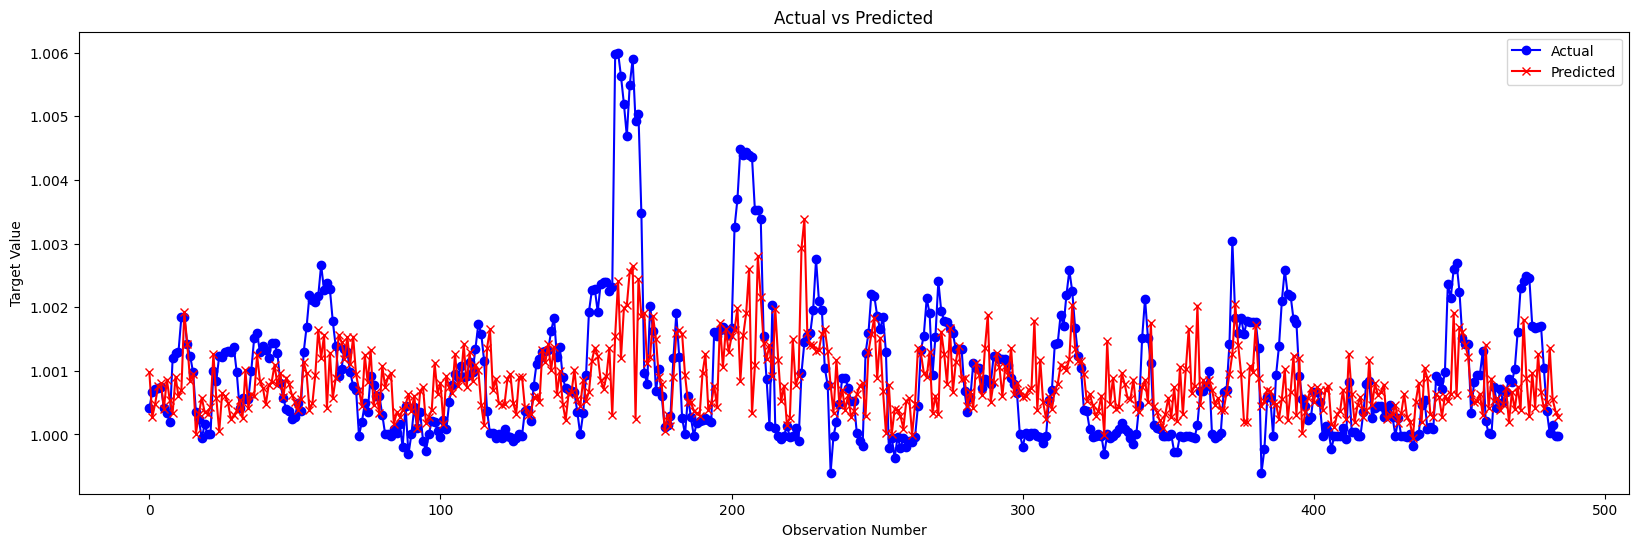

In [284]:
import matplotlib.pyplot as plt

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(20, 6))
plt.plot(y_selected_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(ensemble_preds[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [288]:
## BECKTESTING
test_return = 1.0
i=0
j=0
while i < len(y_selected_test):
    if ensemble_preds[i] > 1.002:
        j=j+1
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])
        if y_selected_test.values[i] < ensemble_preds[i]: 
            test_return = test_return  * (( X_test['return'].iloc[i]- 0.001  - 0.00025))
            i = i+1
        else:
            test_return = test_return * (( ensemble_preds[i] - 0.001 - 0.00025))
            i = i+1
    else:
        i = i+1
print("test_return:", test_return)
print('len(y_selected_test)):', len(y_selected_test))
print('number of trading:', j)

test_return: 0.9940605216154921
len(y_selected_test)): 485
number of trading: 13


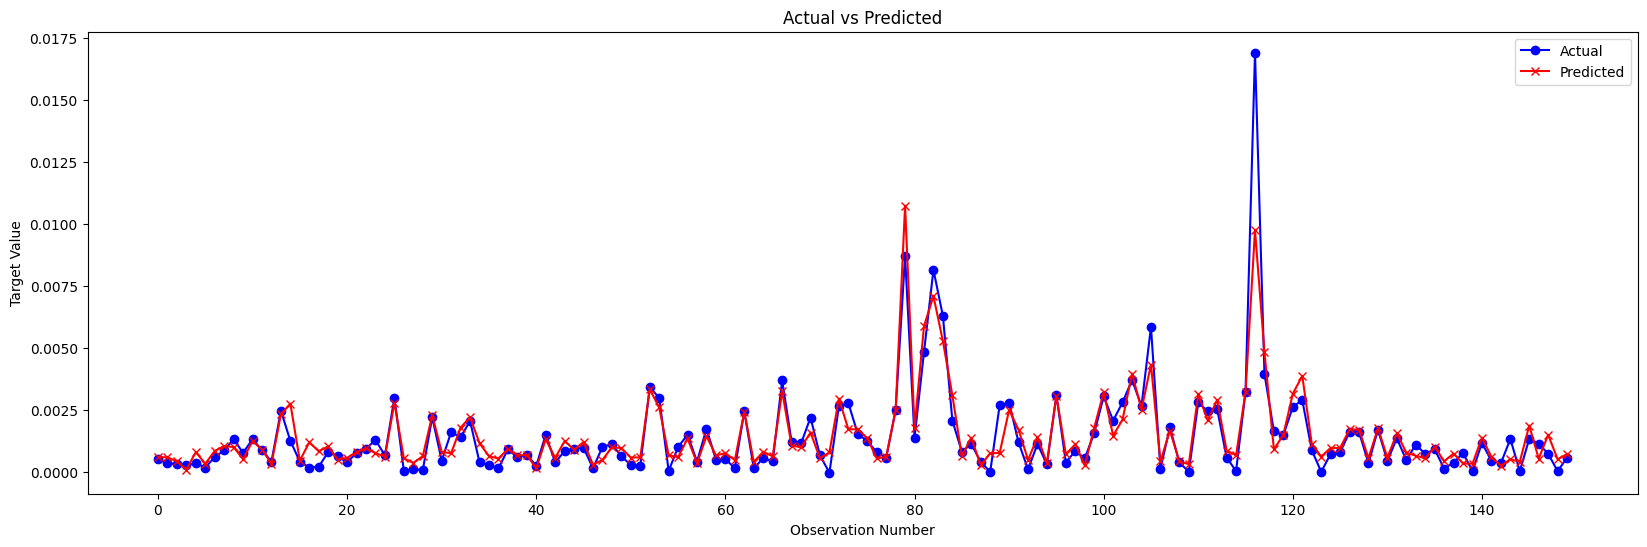

In [29]:
## BASELINE features only
# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(20, 6))

k = 100
figure_range = [i * 10 for i in range(k, k + 150)]

# begin_period = 400 * 10
# end_period = begin_period + 400 
plt.plot(y_selected_test.values[figure_range], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(ensemble_preds[figure_range], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()

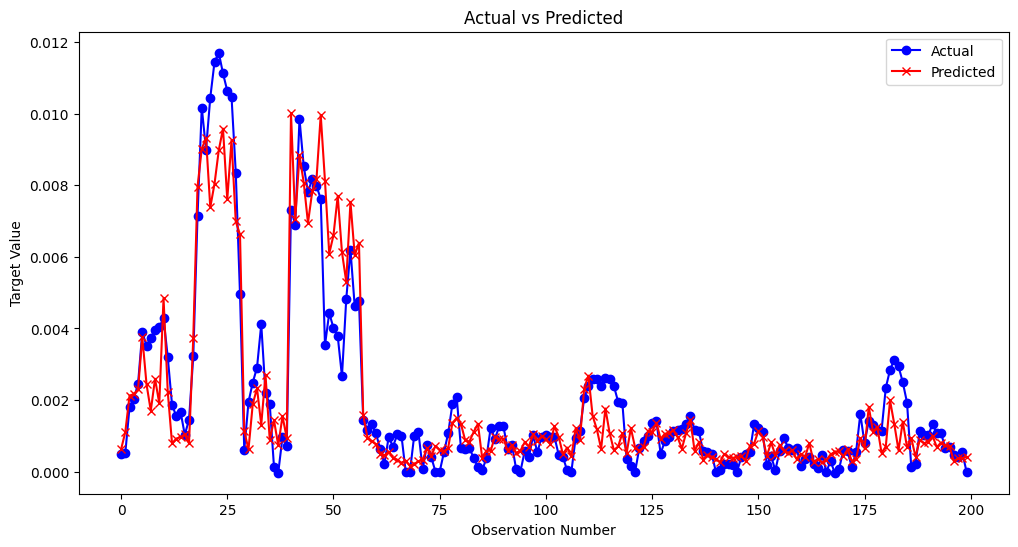

In [30]:
import matplotlib.pyplot as plt

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(12, 6))
begin_period = 4000
end_period = begin_period + 200

plt.plot(y_selected_test.values[begin_period:end_period], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(ensemble_preds[begin_period:end_period], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [ ]:
# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(20, 6))

k = 100
figure_range = [i * 10 for i in range(k, k + 150)]

# begin_period = 400 * 10
# end_period = begin_period + 400 
plt.plot(y_test.values[figure_range], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(ensemble_preds[figure_range], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.plot(lgbm_predictions[figure_range], label='Predicted', color='green', marker='x')  # 첫 100개 데이터
plt.axhline(y=0.001, color='red', linestyle='--', label='Y = 0.001')
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [ ]:
# Find indices of positive values
positive_indices = np.where(ensemble_preds > 0.001)
print("Indices of positive values:", positive_indices)
temp_y_pred = ensemble_preds[positive_indices]
temp_y_test = y_test.values[positive_indices]

# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(20, 6))

k = 100
figure_range = [i * 10 for i in range(k, k + 250)]

# begin_period = 400 * 10
# end_period = begin_period + 400 
plt.plot(temp_y_test[figure_range], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(temp_y_pred[figure_range], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.axhline(y=0.001, color='red', linestyle='--', label='Y = 0.001')
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [120]:
## BECKTESTING

test_return = 1.0
i=0
while i < len(y_test):
    if ensemble_preds[i] > 0.001:
        # print("ensemble_preds[i]:", ensemble_preds[i])
        # print("y_test.values[i]:", y_test.values[i])

        test_return = test_return * (1+( y_test.values[i] - 0.001))
    i = i+10

print("test_return:", test_return)


test_return: 1.8140518691096776


## 모델 저장하기

In [129]:
import lightgbm as lgb
import joblib

In [153]:
joblib.dump(lgbm_selected_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model_{}_v{}.joblib'.format(coin,vn))
joblib.dump(lgbm_baseline_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_baseline_model_{}_v{}.joblib'.format(coin,vn))

# Save the model
# joblib.dump(xgb_model, 'xgboost_model.pkl')
# lgbm_selected_model.save_model('D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model.txt')

# joblib.dump(lgbm_selected_model, 'D:\\OneDrive - 한동대학교\\PROJECT\\트머프로젝트\\trading program\\lgbm_selected_model.txt')
# joblib.dump(cat_model, 'cat_model.pkl')

gc.collect()


14206

In [154]:
X_selected_vars_list = X_selected_train.columns.tolist()
joblib.dump(X_selected_vars_list, '.\\trading program\\X_selected_vars_list_{}_v{}.pkl'.format(coin,vn))

['.\\trading program\\X_selected_vars_list_BTC_v10_5000_1.pkl']

In [155]:
X_baseline_vars_list = X_baseline.columns.tolist()
joblib.dump(X_baseline_vars_list, '.\\trading program\\X_baseline_vars_list_{}_v{}.pkl'.format(coin,vn))

['.\\trading program\\X_baseline_vars_list_BTC_v10_5000_1.pkl']

In [134]:
# Find common values of A and B
common_values = set(X_selected_vars_list) & set(X_baseline_vars_list)

# Get A' (unique values in A not present in B)
baseline_X_varlist_2 = list(set(X_selected_vars_list) - common_values)

In [135]:
# X_baseline_vars_list_in_selected = X_baseline_2.columns.tolist()
joblib.dump(baseline_X_varlist_2, '.\\trading program\\X_baseline_vars_list_in_selected_{}_v{}.pkl'.format(coin,vn))

['.\\trading program\\X_baseline_vars_list_in_selected_BTC_v10_5000_1.pkl']

## XGBoost + LGBM + CatBoost + GBM 
0.3659855769571725 (아주아주 조금 줄었음)

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

# 데이터 로드 및 처리
# df3 = pd.read_csv('your_data.csv')

# 타겟 변수와 피처 분리
target_var = 'dv5_realized_volatility_mean0'
X = df4.drop(target_var, axis=1)
y = df4[target_var]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 피팅
xgb_model = XGBRegressor(tree_method='hist')
xgb_model.fit(X_train, y_train)

lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)

cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_train, y_train)

gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

# 모든 모델의 예측값 계산
xgb_preds = xgb_model.predict(X_test)
lgbm_preds = lgbm_model.predict(X_test)
cat_preds = cat_model.predict(X_test)
gbm_preds = gbm_model.predict(X_test)

# 네 모델의 예측값의 평균으로 최종 예측 생성
ensemble_preds_all = (xgb_preds + lgbm_preds + cat_preds + gbm_preds) / 4

# RMSPE 계산 함수 정의 및 계산
def calculate_rmspe(y_true, y_predicted):
    loss = np.sqrt(np.mean(np.square((y_true - y_predicted) / (y_true + 1e-8))))
    return loss

final_rmspe_all = calculate_rmspe(y_test, ensemble_preds_all)
print(f"Final RMSPE: {final_rmspe_all}")
# 0.3659855769571725


Final RMSPE: 0.3659855769571725


In [26]:
print(f"Final RMSPE: {final_rmspe_all}")

Final RMSPE: 0.3659855769571725


In [ ]:
# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(ensemble_preds_all[:100], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()

## XGBoost + LGBM + CatBoost + RandomForest 

In [29]:
from sklearn.ensemble import RandomForestRegressor

# ... 이전의 데이터 로드 및 타겟 변수와 피처 분리 코드 ...

# Random Forest 모델 생성 및 피팅
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# 모든 모델의 예측값 계산
xgb_preds = xgb_model.predict(X_test)
lgbm_preds = lgbm_model.predict(X_test)
cat_preds = cat_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# 네 모델의 예측값의 평균으로 최종 예측 생성
ensemble_preds_final = (xgb_preds + lgbm_preds + cat_preds + rf_preds) / 4

# RMSPE 계산 함수 정의
def calculate_rmspe(y_true, y_predicted):
    loss = np.sqrt(np.mean(np.square((y_true - y_predicted) / (y_true + 1e-8))))
    return loss

# RMSPE 계산
final_rmspe = calculate_rmspe(y_test, ensemble_preds_final)
print(f"Final RMSPE: {final_rmspe}")

In [ ]:
# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(ensemble_preds_final[:100], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()

## XGBoost + LGBM + Adaboost (에러남)
adaboost 그냥 빼지 뭐 

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

# 모델 재피팅을 위한 선택된 피처로 데이터셋 준비
X_selected_train = X_train[top_20_features]
X_selected_test = X_test[top_20_features]

# XGBoost 모델 재피팅
xgb_model.fit(X_selected_train, y_train)

# LightGBM 모델 재피팅
lgbm_model.fit(X_selected_train, y_train)

# AdaBoost 모델 재피팅
# Adaboost 모델 생성 및 피팅
ada_model = AdaBoostRegressor()
ada_model.fit(X_selected_train, y_train)

# 모든 모델의 예측값 계산
xgb_preds = xgb_model.predict(X_selected_test)
lgbm_preds = lgbm_model.predict(X_selected_test)
ada_preds = ada_model.predict(X_selected_test)

# 세 모델의 예측값의 평균으로 최종 예측 생성
ensemble_preds = (xgb_preds + lgbm_preds + ada_preds) / 3

# RMSPE 계산 및 출력
# RMSPE 계산 함수 정의 및 계산
def calculate_rmspe(y_true, y_predicted):
    loss = np.sqrt(np.mean(np.square((y_true - y_predicted) / (y_true + 1e-8))))
    return loss
final_rmspe = calculate_rmspe(y_test, ensemble_preds)
print(f"Final RMSPE: {final_rmspe}")


NameError: name 'ada_model' is not defined

In [ ]:
# 실제 값과 예측 값 비교를 위한 그래프
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', color='blue', marker='o')  # 첫 100개 데이터
plt.plot(ensemble_preds[:100], label='Predicted', color='red', marker='x')  # 첫 100개 데이터
plt.title('Actual vs Predicted')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()